In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import statsmodels.api as sm
from sklearn.svm import SVR
from catboost import CatBoostRegressor

import time
import warnings

from __future__ import annotations
from typing import Iterable, Optional, List, Dict, Tuple
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
def _patch_ct(ct: ColumnTransformer):
    try:
        params = ct.get_params(deep=False)
        if "force_int_remainder_cols" in params:
            val = params["force_int_remainder_cols"]
            if val == "deprecated" or not isinstance(val, (bool,)):
                ct.set_params(force_int_remainder_cols=False)
    except Exception:
        if hasattr(ct, "__dict__") and "force_int_remainder_cols" in ct.__dict__:
            del ct.__dict__["force_int_remainder_cols"]

def patch_sklearn_objects(obj):
    if isinstance(obj, ColumnTransformer):
        _patch_ct(obj)
        for _, trans, _ in getattr(obj, "transformers", []):
            if isinstance(trans, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(trans)
        return obj

    if isinstance(obj, Pipeline):
        for _, step in obj.steps:
            if isinstance(step, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(step)
        return obj

    for attr in ("named_steps", "_final_estimator"):
        if hasattr(obj, attr):
            sub = getattr(obj, attr)
            try:
                patch_sklearn_objects(sub)
            except Exception:
                pass
    return obj

In [4]:
Ames_original = pd.read_csv('Ames_HousePrice.csv', index_col=0)

Ames = Ames_original.copy()

In [178]:
# Targeted Feature Engineering
Ames["GrLivArea_per_LotArea"] = Ames["GrLivArea"] / (Ames["LotArea"] + 1)
Ames["TotalSF"] = Ames["GrLivArea"] + Ames["TotalBsmtSF"]
Ames["HouseAge"] = Ames["YrSold"].astype(int) - Ames["YearBuilt"].astype(int)
Ames["HouseAgeSinceRemod"] = Ames["YrSold"].astype(int) - Ames["YearRemodAdd"].astype(int)
Ames["WasRemodeled"] = Ames['YearRemodAdd'] > Ames["YearBuilt"].astype(int)

bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
Ames[bath_cols] = Ames[bath_cols].fillna(0)
Ames['TotalBaths'] = Ames['FullBath'] + 0.5 * Ames['HalfBath'] + 1.2 * Ames['BsmtFullBath'] + 0.6 * Ames['BsmtHalfBath']

garage_cols = ['GarageArea', 'GarageCars']
Ames[garage_cols] = Ames[garage_cols].fillna(0)

basement_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
Ames[basement_cols] = Ames[basement_cols].fillna(0)

Ames['MasVnrArea'] = Ames['MasVnrArea'].fillna(0)
Ames['PoolArea'] = Ames['PoolArea'].fillna(0)

# mapping dictionary
style_map = {
    "1Story": "Ranch",
    "SFoyer": "Ranch",
    "SLvl": "Ranch",
    "2Story": "Colonial",
    "2.5Fin": "Colonial",
    "2.5Unf": "Colonial",
    "1.5Fin": "Other",
    "1.5Unf": "Other"
}

# apply to dataset
Ames["RanchColonial"] = Ames["HouseStyle"].map(style_map)

# Convert the below numeric features to categorical features
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')
Ames['WasRemodeled'] = Ames['WasRemodeled'].astype('object')


# Add Interactions
Ames['GrLivArea_x_Qual'] = Ames['GrLivArea'] * Ames['OverallQual']
Ames['TotalSF_x_Qual'] = Ames['TotalSF'] * Ames['OverallQual']


X_fe = Ames.drop(columns=['SalePrice','PID'])
y = Ames['SalePrice']

In [179]:
# === ONE-CELL START: encoders + pipelines + CV helper (no-TTR, short params) ===
# ----------------------------- Ordinal maps -----------------------------
ORDINAL_ORDER: Dict[str, List[str]] = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

# --------------------- Utilities (metrics + helpers) --------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

from pandas.api.types import CategoricalDtype
def _is_object_like(s: pd.Series) -> bool:
    return s.dtype.kind in ("O", "b") or isinstance(s.dtype, CategoricalDtype)

# --------------------------- Quantile capper ----------------------------
class QuantileCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q: float = 0.01, upper_q: float = 0.99):
        self.lower_q = lower_q
        self.upper_q = upper_q

    def fit(self, X, y=None):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.feature_names_in_ = list(df.columns)
        self.lower_ = df.quantile(self.lower_q)
        self.upper_ = df.quantile(self.upper_q)
        return self

    def transform(self, X):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.feature_names_in_)
        df = df.clip(self.lower_, self.upper_, axis=1)
        return df.infer_objects(copy=False)   # <--- this silences the warning

    def get_feature_names_out(self, input_features=None):
        return np.asarray(self.feature_names_in_, dtype=object)

# ------------------------- Preprocessor builder -------------------------
def build_preprocessor(
    df: pd.DataFrame,
    *,
    mode: str = "linear",  # 'linear' -> log/scale; 'tree' -> no log/scale on numerics
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,          # (linear mode only)
    scale_features: Optional[Iterable[str]] = None,    # (linear mode only)
    zero_impute_cols: Optional[Iterable[str]] = None   # exact zeros for these numerics
) -> ColumnTransformer:

    if mode not in {"linear", "tree"}:
        raise ValueError("mode must be 'linear' or 'tree'")

    num_all = df.select_dtypes(include=["number"]).columns.tolist()
    cat_all = [c for c in df.columns if _is_object_like(df[c])]

    ordinal_explicit = [c for c in ORDINAL_ORDER.keys() if c in df.columns and c != "Electrical"]
    nominal_all = [c for c in cat_all if c not in ORDINAL_ORDER.keys()]

    zero_impute_cols = list(zero_impute_cols or ["BsmtFullBath", "BsmtHalfBath"])
    zero_impute_cols = [c for c in zero_impute_cols if c in num_all]

    default_cap = [
        "LotArea","LotFrontage","MasVnrArea","TotalBsmtSF",
        "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
        "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
        "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
        "3SsnPorch","ScreenPorch","PoolArea","MiscVal",
        "TotalSF","GrLivArea_per_LotArea",
    ]
    numeric_cap = set(numeric_cap or default_cap) & set(num_all)

    if mode == "linear":
        log_cols = set(log_cols or [
            "LotArea", "LotFrontage", "MasVnrArea",
            "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
            "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
            "3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
        ])
        scale_features = set(scale_features or (
            {
                "GrLivArea","LotFrontage","LotArea","MasVnrArea",
                "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
                "1stFlrSF","2ndFlrSF","LowQualFinSF","GarageArea",
                "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
                "ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
            }
            | {"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
               "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces",
               "GarageCars","TotalBaths"}
            | {"OverallQual","OverallCond"}
            | {"HouseAge","HouseAgeSinceRemod","GarageAge"}
        ))
    else:
        log_cols = set()
        scale_features = set()

    num_log_cap   = sorted((log_cols & numeric_cap) & set(num_all))
    num_log_plain = sorted((log_cols - numeric_cap) & set(num_all))
    num_cap_only  = sorted((numeric_cap - log_cols) & set(num_all))
    used_linear_buckets = set(num_log_cap) | set(num_log_plain) | set(num_cap_only)
    num_plain = sorted([c for c in num_all if c not in used_linear_buckets])

    def make_imputer_for(cols: List[str]) -> ColumnTransformer:
        zero_cols = [c for c in cols if c in zero_impute_cols]
        mean_cols = [c for c in cols if c not in zero_impute_cols]
        transformers = []
        if zero_cols:
            transformers.append(("zero_imp", SimpleImputer(strategy="constant", fill_value=0), zero_cols))
        if mean_cols:
            transformers.append(("mean_imp", SimpleImputer(strategy="mean"), mean_cols))
        return ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

    def numeric_branch(cols: List[str], *, cap: bool, log: bool, scale: bool):
        if not cols:
            return None
        steps = []
        if cap:
            steps.append(("cap", QuantileCapper(lower_q=lower_q, upper_q=upper_q)))
        steps.append(("impute", make_imputer_for(cols)))
        if log:
            steps.append(("log1p", FunctionTransformer(np.log1p, validate=False)))
        if scale:
            steps.append(("scale", StandardScaler()))
        return ("_tmp", Pipeline(steps=steps), cols)

    branches = []
    branches += [numeric_branch(num_log_cap,   cap=True,  log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_log_plain, cap=False, log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_cap_only,  cap=True,  log=False,           scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_plain,     cap=False, log=False,           scale=(mode=="linear"))] or []
    branches = [b for b in branches if b is not None]

    electrical_pipe = Pipeline(steps=[
        ("impute_mf", SimpleImputer(strategy="most_frequent")),
        ("ordinal",   OrdinalEncoder(categories=[ORDINAL_ORDER["Electrical"]],
                                     handle_unknown="use_encoded_value", unknown_value=-1)),
    ]) if "Electrical" in df.columns else "drop"

    if "Electrical" in nominal_all: nominal_all.remove("Electrical")
    if "Electrical" in ordinal_explicit: ordinal_explicit.remove("Electrical")

    ordinal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("ordinal", OrdinalEncoder(categories=[ORDINAL_ORDER[c] for c in ordinal_explicit],
                                       handle_unknown="use_encoded_value", unknown_value=-1))
        ])
        if ordinal_explicit else "drop"
    )

    nominal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])
        if nominal_all else "drop"
    )

    transformers = []
    if "Electrical" in df.columns:
        transformers.append(("elect", electrical_pipe, ["Electrical"]))
    name_map = ["num_log_cap","num_log_plain","num_cap","num_plain"]
    for i, b in enumerate(branches):
        transformers.append((name_map[i], b[1], b[2]))
    if ordinal_explicit:
        transformers.append(("ordinal", ordinal_pipe, ordinal_explicit))
    if nominal_all:
        transformers.append(("nominal", nominal_pipe, nominal_all))

    pre = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        sparse_threshold=0.3,
        verbose_feature_names_out=False
    )
    return pre



def make_catboost_pipe(df_schema, **cb_params):
    pre = build_preprocessor(df_schema, mode="tree", log_cols=[], scale_features=[])
    # set safe defaults only if not provided
    cb_params = dict(cb_params)
    cb_params.setdefault("loss_function", "RMSE")
    cb_params.setdefault("random_state", 42)
    cb_params.setdefault("verbose", 0)
    cb_params.setdefault("thread_count", -1)
    reg = CatBoostRegressor(**cb_params)
    return Pipeline([("prep", pre), ("reg", reg)])

# ---------------------- Quick CV leaderboard helper --------------------
def cv_eval_models(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    models: List[Tuple[str, BaseEstimator]],
    *,
    cv: int = 5,
    random_state: int = 42,
    log_target: bool = True,     # <— evaluator handles log target (since no TTR)
) -> pd.DataFrame:

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rows = []

    for name, est in models:
        fold_rmses, oof = [], np.zeros(len(y_np), dtype=float)
        for tr, va in kf.split(X):
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y_np[tr], y_np[va]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            est.fit(X_tr, y_tr_used)

            pred = est.predict(X_va)
            if log_target:
                pred = np.expm1(pred)

            fold_rmses.append(rmse(y_va, pred))
            oof[va] = pred

        # full-fit for r2_full
        y_full_used = np.log1p(y_np) if log_target else y_np
        est.fit(X, y_full_used)
        y_full = est.predict(X)
        if log_target:
            y_full = np.expm1(y_full)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_score(y_np, oof)),
            "r2_full": float(r2_score(y_np, y_full)),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

In [200]:
from sklearn.model_selection import train_test_split
X_tr, X_ho, y_tr, y_ho = train_test_split(
    X_fe, y, test_size=0.20, random_state=42
)

In [201]:
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV

# Your pipe factory (already in your notebook)
# def make_catboost_pipe(df_schema, **cb_params): ...

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

def tune_baseline(X, y, n_iter=40, random_state=42):
    pipe = make_catboost_pipe(X)  # no params => defaults inside

    param_dist = {
        "reg__n_estimators":      [700, 900, 1100, 1300, 1500],
        "reg__learning_rate":     np.logspace(np.log10(0.01), np.log10(0.2), 20),
        "reg__depth":             [4, 5, 6, 7, 8, 9],
        "reg__l2_leaf_reg":       np.logspace(-2, np.log10(50), 20),
        "reg__subsample":         [0.6, 0.7, 0.8, 0.9, 1.0],
        "reg__colsample_bylevel": [0.6, 0.7, 0.8, 0.9, 1.0],
    }

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=cv5,
        n_jobs=-1,
        random_state=random_state,
        verbose=1,
        refit=True,
    )
    search.fit(X, y)
    print("Baseline best params:", search.best_params_)
    print("Baseline best CV RMSE:", -search.best_score_)
    return search

In [202]:
baseline = tune_baseline(X_tr, y_tr, n_iter=40)
base_params = baseline.best_params_
base_cv_rmse = -baseline.best_score_
base_model   = baseline.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Baseline best params: {'reg__subsample': 0.8, 'reg__n_estimators': 1500, 'reg__learning_rate': np.float64(0.041331138302441096), 'reg__l2_leaf_reg': np.float64(0.09406177265238869), 'reg__depth': 4, 'reg__colsample_bylevel': 0.6}
Baseline best CV RMSE: 20654.84731365652


In [203]:
from sklearn.model_selection import GridSearchCV

def refine_min_leaf(X, y, base_params, grid=(1, 3, 5, 10, 20)):
    pipe = make_catboost_pipe(X)
    grid_params = dict(base_params)  # copy
    # we’ll grid only this one dimension; keep others at baseline best
    param_grid = {
        **{k:[v] for k,v in grid_params.items()},
        "reg__min_data_in_leaf": list(grid),
    }
    g = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=cv5,
        n_jobs=-1,
        verbose=1,
        refit=True,
    )
    g.fit(X, y)
    print("min_data_in_leaf best params:", g.best_params_)
    print("min_data_in_leaf best CV RMSE:", -g.best_score_)
    return g

In [204]:
def refine_grow_policy(X, y, base_params, policies=("SymmetricTree","Depthwise")):
    pipe = make_catboost_pipe(X)
    param_grid = {
        **{k:[v] for k,v in base_params.items()},
        "reg__grow_policy": list(policies),
    }
    g = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=cv5,
        n_jobs=-1,
        verbose=1,
        refit=True,
    )
    g.fit(X, y)
    print("grow_policy best params:", g.best_params_)
    print("grow_policy best CV RMSE:", -g.best_score_)
    return g

In [205]:
leaf_refine = refine_min_leaf(X_tr, y_tr, base_params, grid=(1,3,5,10))
leaf_cv_rmse = -leaf_refine.best_score_

grow_refine = refine_grow_policy(X_tr, y_tr, base_params)
grow_cv_rmse = -grow_refine.best_score_

# pick the best set among (baseline, leaf_refine, grow_refine)
candidates = [
    ("baseline", base_params, base_cv_rmse, base_model),
    ("min_leaf", leaf_refine.best_params_, leaf_cv_rmse, leaf_refine.best_estimator_),
    ("grow_policy", grow_refine.best_params_, grow_cv_rmse, grow_refine.best_estimator_),
]
winner_name, winner_params, winner_cv_rmse, winner_model = sorted(candidates, key=lambda x: x[2])[0]
print(f"Winner after targeted refinements: {winner_name} | CV RMSE={winner_cv_rmse:,.0f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
min_data_in_leaf best params: {'reg__colsample_bylevel': 0.6, 'reg__depth': 4, 'reg__l2_leaf_reg': np.float64(0.09406177265238869), 'reg__learning_rate': np.float64(0.041331138302441096), 'reg__min_data_in_leaf': 1, 'reg__n_estimators': 1500, 'reg__subsample': 0.8}
min_data_in_leaf best CV RMSE: 20654.84731365652
Fitting 5 folds for each of 2 candidates, totalling 10 fits
grow_policy best params: {'reg__colsample_bylevel': 0.6, 'reg__depth': 4, 'reg__grow_policy': 'SymmetricTree', 'reg__l2_leaf_reg': np.float64(0.09406177265238869), 'reg__learning_rate': np.float64(0.041331138302441096), 'reg__n_estimators': 1500, 'reg__subsample': 0.8}
grow_policy best CV RMSE: 20654.84731365652
Winner after targeted refinements: baseline | CV RMSE=20,655


In [206]:
def jitter(vals, pct=0.25, n=7, clip=None):
    a = []
    for t in np.linspace(-pct, pct, n):
        a.append(vals*(1+t))
    if clip:
        lo, hi = clip
        a = [min(max(x, lo), hi) for x in a]
    return sorted(set(a))

def micro_search(X, y, winner_params, n_iter=20):
    pipe = make_catboost_pipe(X)

    p = winner_params
    param_dist = {
        "reg__n_estimators":      [max(400, int(p["reg__n_estimators"]*f)) for f in [0.85, 1.0, 1.15, 1.3]],
        "reg__learning_rate":     jitter(float(p["reg__learning_rate"]), pct=0.35, n=9, clip=(0.005, 0.2)),
        "reg__l2_leaf_reg":       jitter(float(p["reg__l2_leaf_reg"]),   pct=0.75, n=9, clip=(0.01, 50.0)),
        "reg__depth":             [p.get("reg__depth", 6)],
        "reg__subsample":         [p.get("reg__subsample", 0.8)],
        "reg__colsample_bylevel": [p.get("reg__colsample_bylevel", 0.8)],
    }
    # carry optional knobs if present
    if "reg__min_data_in_leaf" in p:
        param_dist["reg__min_data_in_leaf"] = [p["reg__min_data_in_leaf"]]
    if "reg__grow_policy" in p:
        param_dist["reg__grow_policy"] = [p["reg__grow_policy"]]

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=cv5,
        n_jobs=-1,
        random_state=42,
        verbose=1,
        refit=True,
    )
    search.fit(X, y)
    print("Micro best params:", search.best_params_)
    print("Micro best CV RMSE:", -search.best_score_)
    return search

micro = micro_search(X_tr, y_tr, winner_params, n_iter=20)
final_params = micro.best_params_
final_cv_rmse = -micro.best_score_
final_model   = micro.best_estimator_
print(f"Final winner | CV RMSE={final_cv_rmse:,.0f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Micro best params: {'reg__subsample': 0.8, 'reg__n_estimators': 1275, 'reg__learning_rate': np.float64(0.04856408750536828), 'reg__l2_leaf_reg': np.float64(0.07642519028006581), 'reg__depth': 4, 'reg__colsample_bylevel': 0.6}
Micro best CV RMSE: 20655.55420214499
Final winner | CV RMSE=20,656


In [207]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

pred_ho = final_model.predict(X_ho)
rmse = np.sqrt(mean_squared_error(y_ho, pred_ho))
mae  = mean_absolute_error(y_ho, pred_ho)
r2   = r2_score(y_ho, pred_ho)

print(f"Holdout -> RMSE: {rmse:,.0f} | MAE: {mae:,.0f} | R2: {r2:.3f}")

Holdout -> RMSE: 19,126 | MAE: 12,063 | R2: 0.941


In [208]:
# ============================================
# CatBoost tuning helper suite (regression)
# ============================================

import numpy as np
from dataclasses import dataclass
from typing import Dict, Any, Iterable, Tuple, List

from sklearn.model_selection import (
    train_test_split, KFold, RandomizedSearchCV, GridSearchCV
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- shared CV object (stable across all calls) ---
CV5 = KFold(n_splits=5, shuffle=True, random_state=42)


# -------------------------
# 0) Holdout split (once)
# -------------------------
def split_holdout(X, y, test_size=0.20, random_state=42):
    """Return (X_tr, X_ho, y_tr, y_ho) with a single consistent split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


# -------------------------
# 1) Baseline search
# -------------------------
def tune_baseline(X, y, n_iter=40, random_state=42):
    """Focus on core CatBoost knobs; good bang-for-buck."""
    pipe = make_catboost_pipe(X)

    param_dist = {
        "reg__n_estimators":      [700, 900, 1100, 1300, 1500],
        "reg__learning_rate":     np.logspace(np.log10(0.01), np.log10(0.2), 20),
        "reg__depth":             [4, 5, 6, 7, 8, 9],
        "reg__l2_leaf_reg":       np.logspace(-2, np.log10(50), 20),
        "reg__subsample":         [0.6, 0.7, 0.8, 0.9, 1.0],
        "reg__colsample_bylevel": [0.6, 0.7, 0.8, 0.9, 1.0],
    }

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=CV5,
        n_jobs=-1,
        random_state=random_state,
        verbose=1,
        refit=True,
    )
    search.fit(X, y)
    print("Baseline best params:", search.best_params_)
    print("Baseline best CV RMSE:", -search.best_score_)
    return search


# -----------------------------------------
# 2A) Targeted refinement: min_data_in_leaf
# -----------------------------------------
def refine_min_leaf(X, y, base_params: Dict[str, Any], grid: Iterable[int] = (1, 3, 5, 10, 20)):
    """Probe min_data_in_leaf while keeping all other params at baseline best."""
    pipe = make_catboost_pipe(X)
    param_grid = {
        **{k: [v] for k, v in base_params.items()},
        "reg__min_data_in_leaf": list(grid),
    }
    g = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=CV5,
        n_jobs=-1,
        verbose=1,
        refit=True,
    )
    g.fit(X, y)
    print("min_data_in_leaf best params:", g.best_params_)
    print("min_data_in_leaf best CV RMSE:", -g.best_score_)
    return g


# --------------------------------
# 2B) Targeted refinement: policy
# --------------------------------
def refine_grow_policy(X, y, base_params: Dict[str, Any], policies=("SymmetricTree", "Depthwise")):
    """Probe grow_policy while keeping all other params at baseline best."""
    pipe = make_catboost_pipe(X)
    param_grid = {
        **{k: [v] for k, v in base_params.items()},
        "reg__grow_policy": list(policies),
    }
    g = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=CV5,
        n_jobs=-1,
        verbose=1,
        refit=True,
    )
    g.fit(X, y)
    print("grow_policy best params:", g.best_params_)
    print("grow_policy best CV RMSE:", -g.best_score_)
    return g


# -----------------------------------------
# 3) Micro-search around a chosen winner
# -----------------------------------------
def _jitter(val: float, pct=0.25, n=7, clip: Tuple[float, float] | None = None):
    grid = [val * (1 + t) for t in np.linspace(-pct, pct, n)]
    if clip:
        lo, hi = clip
        grid = [min(max(x, lo), hi) for x in grid]
    return sorted(set(grid))

def micro_search(X, y, winner_params: Dict[str, Any], n_iter=20, random_state=42):
    """Small random search centered around a winner's params."""
    pipe = make_catboost_pipe(X)

    p = winner_params
    param_dist = {
        "reg__n_estimators":      [max(400, int(p["reg__n_estimators"] * f)) for f in [0.85, 1.0, 1.15, 1.3]],
        "reg__learning_rate":     _jitter(float(p["reg__learning_rate"]), pct=0.35, n=9, clip=(0.005, 0.2)),
        "reg__l2_leaf_reg":       _jitter(float(p["reg__l2_leaf_reg"]),   pct=0.75, n=9, clip=(0.01, 50.0)),
        "reg__depth":             [p.get("reg__depth", 6)],
        "reg__subsample":         [p.get("reg__subsample", 0.8)],
        "reg__colsample_bylevel": [p.get("reg__colsample_bylevel", 0.8)],
    }
    # carry optional knobs if present
    if "reg__min_data_in_leaf" in p:
        param_dist["reg__min_data_in_leaf"] = [p["reg__min_data_in_leaf"]]
    if "reg__grow_policy" in p:
        param_dist["reg__grow_policy"] = [p["reg__grow_policy"]]

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=CV5,
        n_jobs=-1,
        random_state=random_state,
        verbose=1,
        refit=True,
    )
    search.fit(X, y)
    print("Micro best params:", search.best_params_)
    print("Micro best CV RMSE:", -search.best_score_)
    return search


# -------------------------
# 4) Holdout evaluation
# -------------------------
@dataclass
class EvalReport:
    rmse: float
    mae: float
    r2: float

def evaluate_holdout(model, X_ho, y_ho) -> EvalReport:
    pred = model.predict(X_ho)
    rmse = float(np.sqrt(mean_squared_error(y_ho, pred)))
    mae  = float(mean_absolute_error(y_ho, pred))
    r2   = float(r2_score(y_ho, pred))
    print(f"Holdout -> RMSE: {rmse:,.0f} | MAE: {mae:,.0f} | R2: {r2:.3f}")
    return EvalReport(rmse, mae, r2)


# -------------------------
# 5) Orchestrator (one call)
# -------------------------
def run_full_tuning(X, y, n_iter_baseline=40, n_iter_micro=20):
    """
    Full flow:
      - holdout split
      - baseline
      - refine (min_leaf, grow_policy)
      - pick best by CV RMSE
      - micro-search around winner
      - holdout eval
    Returns a dict with everything you might care about.
    """
    X_tr, X_ho, y_tr, y_ho = split_holdout(X, y, test_size=0.20, random_state=42)

    # Baseline
    base = tune_baseline(X_tr, y_tr, n_iter=n_iter_baseline)
    base_info = ("baseline", base.best_params_, -base.best_score_, base.best_estimator_)

    # Refinements
    leaf = refine_min_leaf(X_tr, y_tr, base.best_params_, grid=(1, 3, 5, 10))
    leaf_info = ("min_leaf", leaf.best_params_, -leaf.best_score_, leaf.best_estimator_)

    grow = refine_grow_policy(X_tr, y_tr, base.best_params_)
    grow_info = ("grow_policy", grow.best_params_, -grow.best_score_, grow.best_estimator_)

    # Pick best CV
    candidates = sorted([base_info, leaf_info, grow_info], key=lambda x: x[2])
    winner_stage, winner_params, winner_cv_rmse, winner_model = candidates[0]
    print(f"\nWinner after refinements: {winner_stage} | CV RMSE={winner_cv_rmse:,.0f}")

    # Micro search around winner
    micro = micro_search(X_tr, y_tr, winner_params, n_iter=n_iter_micro)
    final_params = micro.best_params_
    final_cv_rmse = -micro.best_score_
    final_model   = micro.best_estimator_
    print(f"Final winner (micro) | CV RMSE={final_cv_rmse:,.0f}")

    # Holdout
    final_report = evaluate_holdout(final_model, X_ho, y_ho)

    return dict(
        split=dict(X_tr=X_tr, X_ho=X_ho, y_tr=y_tr, y_ho=y_ho),
        baseline=dict(search=base, params=base.best_params_, cv_rmse=-base.best_score_),
        refine_min_leaf=dict(search=leaf, params=leaf.best_params_, cv_rmse=-leaf.best_score_),
        refine_grow_policy=dict(search=grow, params=grow.best_params_, cv_rmse=-grow.best_score_),
        winner_after_refinements=dict(stage=winner_stage, params=winner_params, cv_rmse=winner_cv_rmse, model=winner_model),
        micro=dict(search=micro, params=final_params, cv_rmse=final_cv_rmse, model=final_model),
        holdout_report=final_report,
    )

In [210]:
res = run_full_tuning(X_fe, y, n_iter_baseline=40, n_iter_micro=20)

# Access useful bits:
res["baseline"]["cv_rmse"]
res["winner_after_refinements"]["params"]
res["micro"]["params"]
res["holdout_report"]  # EvalReport(rmse=..., mae=..., r2=...)
best_model = res["micro"]["model"]

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Baseline best params: {'reg__subsample': 0.8, 'reg__n_estimators': 1500, 'reg__learning_rate': np.float64(0.041331138302441096), 'reg__l2_leaf_reg': np.float64(0.09406177265238869), 'reg__depth': 4, 'reg__colsample_bylevel': 0.6}
Baseline best CV RMSE: 20654.84731365652
Fitting 5 folds for each of 4 candidates, totalling 20 fits
min_data_in_leaf best params: {'reg__colsample_bylevel': 0.6, 'reg__depth': 4, 'reg__l2_leaf_reg': np.float64(0.09406177265238869), 'reg__learning_rate': np.float64(0.041331138302441096), 'reg__min_data_in_leaf': 1, 'reg__n_estimators': 1500, 'reg__subsample': 0.8}
min_data_in_leaf best CV RMSE: 20654.84731365652
Fitting 5 folds for each of 2 candidates, totalling 10 fits
grow_policy best params: {'reg__colsample_bylevel': 0.6, 'reg__depth': 4, 'reg__grow_policy': 'SymmetricTree', 'reg__l2_leaf_reg': np.float64(0.09406177265238869), 'reg__learning_rate': np.float64(0.041331138302441096), 'reg__n_esti

In [220]:
from sklearn.model_selection import RandomizedSearchCV, KFold
import numpy as np

good_anchor = {
    "reg__n_estimators":      1500,
    "reg__learning_rate":     0.06,
    "reg__depth":             6,
    "reg__l2_leaf_reg":       6.0,   # search around 3–10
    "reg__subsample":         0.8,
    "reg__colsample_bylevel": 0.8,
}

def jitter(val, pct=0.35, n=9, lo=None, hi=None):
    xs = [val*(1+t) for t in np.linspace(-pct, pct, n)]
    if lo is not None: xs = [max(lo, x) for x in xs]
    if hi is not None: xs = [min(hi, x) for x in xs]
    return sorted(set(xs))

param_dist_guided = {
    "reg__n_estimators":      [1200, 1400, 1500, 1600, 1800],
    "reg__learning_rate":     jitter(good_anchor["reg__learning_rate"], pct=0.30, n=7, lo=0.02, hi=0.12),
    "reg__l2_leaf_reg":       jitter(good_anchor["reg__l2_leaf_reg"],   pct=0.60, n=7, lo=1.0, hi=12.0),
    "reg__depth":             [5, 6, 7],
    "reg__subsample":         [0.8],
    "reg__colsample_bylevel": [0.8],
}

pipe = make_catboost_pipe(X_fe)
guided = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist_guided,
    n_iter=24,
    scoring="neg_root_mean_squared_error",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True,
)
guided.fit(X_fe, y)
print("Guided best params:", guided.best_params_)
print("Guided best CV RMSE:", -guided.best_score_)
guided_best = guided.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Guided best params: {'reg__subsample': 0.8, 'reg__n_estimators': 1400, 'reg__learning_rate': np.float64(0.041999999999999996), 'reg__l2_leaf_reg': np.float64(9.600000000000001), 'reg__depth': 7, 'reg__colsample_bylevel': 0.8}
Guided best CV RMSE: 19274.12688305002


In [221]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
scores = cross_val_score(
    guided_best, X_fe, y,
    scoring="neg_root_mean_squared_error",
    cv=rkf, n_jobs=-1, verbose=0
)
rmse = -scores
print(f"Repeated-CV RMSE: mean={rmse.mean():.1f}, std={rmse.std():.1f}, "
      f"min={rmse.min():.1f}, max={rmse.max():.1f}")

Repeated-CV RMSE: mean=19966.2, std=2969.6, min=15280.4, max=26147.1


In [224]:
import numbers
import numpy as np

REG_PREFIX = "reg__"

# 1) Convert CV params (with 'reg__') → raw CatBoost params
def cv_to_raw_params(cv_params: dict, prefix: str = REG_PREFIX) -> dict:
    raw = {}
    for k, v in cv_params.items():
        if k.startswith(prefix):
            k2 = k[len(prefix):]  # strip 'reg__'
        else:
            # ignore non-reg keys; keep only estimator params
            continue
        # cast numpy scalars to python scalars (CatBoost is fine, but nicer/safer)
        if isinstance(v, np.generic):
            v = v.item()
        raw[k2] = v
    return raw

# 2) Convert raw CatBoost params → CV params (with 'reg__')
def raw_to_cv_params(raw_params: dict, prefix: str = REG_PREFIX) -> dict:
    out = {}
    for k, v in raw_params.items():
        out[prefix + k] = v
    return out

# 3) Convenience: apply CV best_params_ directly to a new Pipeline
def make_pipe_from_cv_best(df_schema, best_params: dict, make_pipe_fn, prefix: str = REG_PREFIX):
    """
    df_schema: your feature schema (e.g., X_fe)
    best_params: dict like cv.best_params_
    make_pipe_fn: your factory, e.g. make_catboost_pipe
    """
    raw = cv_to_raw_params(best_params, prefix=prefix)
    return make_pipe_fn(df_schema, **raw)

In [225]:
# after RandomizedSearchCV(...).fit(X_fe, y)
best_cv_params = cb_fast.best_params_              # has 'reg__...' keys
final_params   = cv_to_raw_params(best_cv_params)  # strip prefix

cb_final = make_catboost_pipe(X_fe, **final_params)
cb_final.fit(X_fe, y)

,steps,"[('prep', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('elect', ...), ('num_log_cap', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [226]:
guided_params = {
    "subsample": 0.8,
    "n_estimators": 1400,
    "learning_rate": 0.042,
    "l2_leaf_reg": 9.6,
    "depth": 7,
    "colsample_bylevel": 0.8,
}

# If you ever need them for a CV search space:
guided_cv_params = raw_to_cv_params(guided_params)  # -> 'reg__...' keys

In [227]:
cb_final = make_pipe_from_cv_best(X_fe, cb_fast.best_params_, make_catboost_pipe)
cb_final.fit(X_fe, y)

,steps,"[('prep', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('elect', ...), ('num_log_cap', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [230]:
import numpy as np
import pandas as pd

# -------- 0) Config you can tweak --------
# If your DF already has TotalBaths computed the classic way, keep it.
# Set overwrite_totalbaths=True to recompute with alternative weights.
BATH_WEIGHTS = (1.0, 0.5, 1.2, 0.6)  # (Full, Half, BsmtFull, BsmtHalf)
OVERWRITE_TOTALBATHS = False

UPGRADES = [
    # Categorical to best / +1 step
    {"feature": "ExterQual",   "to": "best", "upgrade": "ExterQual → best (max)"},
    {"feature": "KitchenQual", "to": "best", "upgrade": "KitchenQual → best (max)"},
    {"feature": "ExterQual",   "step": +1,   "upgrade": "ExterQual +1 step"},
    {"feature": "KitchenQual", "step": +1,   "upgrade": "KitchenQual +1 step"},

    # Numeric deltas
    {"feature": "GarageCars",  "delta": +1.0,  "upgrade": "GarageCars +1.0"},
    {"feature": "TotalBaths",  "delta": +1.0,  "upgrade": "TotalBaths +1.0"},
    {"feature": "TotalSF",     "delta": +200., "upgrade": "TotalSF +200.0"},
    {"feature": "WoodDeckSF",  "delta": +100., "upgrade": "WoodDeckSF +100.0"},
    {"feature": "GarageArea",  "delta": +100., "upgrade": "GarageArea +100.0"},
    {"feature": "OpenPorchSF", "delta": +50.,  "upgrade": "OpenPorchSF +50.0"},
    {"feature": "ScreenPorch", "delta": +50.,  "upgrade": "ScreenPorch +50.0"},
    {"feature": "EnclosedPorch","delta": +50., "upgrade": "EnclosedPorch +50.0"},
]

# Ordinal ladders for “step/best” moves (extend if needed)
ORDINAL_ORDER = {
    'ExterQual':   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
}

# -------- 1) Helpers --------
def ensure_totalbaths(df, overwrite=False,
                      w_full=1.0, w_half=0.5, w_bfull=1.2, w_bhalf=0.6):
    need_cols = ["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"]
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing bath columns: {missing}")
    if overwrite or ("TotalBaths" not in df.columns):
        tb = (
            w_full  * df["FullBath"].fillna(0) +
            w_half  * df["HalfBath"].fillna(0) +
            w_bfull * df["BsmtFullBath"].fillna(0) +
            w_bhalf * df["BsmtHalfBath"].fillna(0)
        )
        df = df.copy()
        df["TotalBaths"] = tb
    return df

def step_ordinal(val, order, step):
    """Move categorical value by ±step within its ordinal order."""
    if pd.isna(val): return val
    if val not in order: return val
    i = order.index(val)
    j = int(np.clip(i + step, 0, len(order)-1))
    return order[j]

def to_best(val, order):
    """Bump categorical to the top of its ladder."""
    if pd.isna(val): return val
    return order[-1] if order else val

def apply_single_upgrade(row, upg):
    """Return a *modified* copy of 'row' with one upgrade applied."""
    row2 = row.copy()
    f = upg["feature"]
    if "delta" in upg:
        # numeric delta
        base = pd.to_numeric(row2.get(f), errors="coerce")
        if pd.isna(base): base = 0.0
        row2[f] = base + upg["delta"]
    elif "step" in upg:
        order = ORDINAL_ORDER.get(f, None)
        if order is None:
            # no ordinal ladder known; skip
            return row2
        row2[f] = step_ordinal(row2.get(f), order, upg["step"])
    elif upg.get("to") == "best":
        order = ORDINAL_ORDER.get(f, None)
        if order is None:
            return row2
        row2[f] = to_best(row2.get(f), order)
    return row2

# -------- 2) Compute residuals on your base data --------
def compute_residuals(cb_pipe, X, y,
                      overwrite_totalbaths=False,
                      bath_weights=BATH_WEIGHTS,
                      id_col="__row_id__"):
    Xb = ensure_totalbaths(
        X, overwrite=overwrite_totalbaths,
        w_full=bath_weights[0], w_half=bath_weights[1],
        w_bfull=bath_weights[2], w_bhalf=bath_weights[3]
    )
    base_pred = cb_pipe.predict(Xb).astype(float)

    df = Xb.copy()
    df["_idx"] = np.arange(len(df))  # <- positional id (unique)
    df["_id_"] = df[id_col] if (id_col in df.columns) else df.index

    y_arr = y.values if isinstance(y, (pd.Series, pd.DataFrame)) else np.asarray(y)
    df["y_true"] = y_arr.astype(float)
    df["base_pred"] = base_pred
    df["residual"] = df["y_true"] - df["base_pred"]
    return df


def simulate_upgrades(cb_pipe, base_df, X,
                      upgrades=UPGRADES,
                      underpriced_top_pct=0.30):
    Xw = X

    k = max(1, int(round(underpriced_top_pct * len(base_df))))
    underpriced = base_df.nlargest(k, "residual").copy()

    rows = []
    # NOTE: name=None returns plain tuples; order matches the column list
    for _idx, _id_, base_pred, y_true in underpriced[["_idx","_id_","base_pred","y_true"]].itertuples(index=False, name=None):
        _idx = int(_idx)
        base_row = Xw.iloc[_idx]

        for upg in upgrades:
            mod_row = apply_single_upgrade(base_row, upg)
            mod_df = pd.DataFrame([mod_row], columns=Xw.columns)
            new_pred = float(cb_pipe.predict(mod_df)[0])

            rows.append({
                "_idx": _idx,
                "_id_": _id_,
                "upgrade": upg["upgrade"],
                "feature": upg["feature"],
                "base_pred": float(base_pred),
                "new_pred": new_pred,
                "uplift": new_pred - float(base_pred),
                "y_true": float(y_true),
            })

    upgrades_long = pd.DataFrame(rows)

    # attach context columns by positional index
    ctx_cols = ["Neighborhood","MSZoning","KitchenQual","OverallQual",
                "GrLivArea","TotalBaths","GarageArea","TotalSF","YearBuilt","YearRemodAdd"]
    for c in ctx_cols:
        if c in Xw.columns:
            upgrades_long[c] = Xw.iloc[upgrades_long["_idx"].to_numpy()][c].to_numpy()

    best_per_home = (
        upgrades_long.sort_values(["_idx","uplift"], ascending=[True, False])
                     .groupby("_idx", as_index=False)
                     .first()
                     .rename(columns={
                         "upgrade":"best_upgrade",
                         "feature":"best_feature",
                         "new_pred":"best_new_pred",
                         "uplift":"best_uplift"
                     })
    )

    candidates_summary = (
        base_df[["_idx","_id_","y_true","base_pred","residual"]]
        .merge(best_per_home, on="_idx", how="left")
        .sort_values(["residual","best_uplift"], ascending=[False, False], ignore_index=True)
    )

    return candidates_summary, upgrades_long

# ======== RUN IT ========
# 1) Compute residuals on your chosen feature frame (X_fe or X_adj)
base_eval = compute_residuals(
    cb_final,                      # <- your fitted pipeline
    X_fe,                          # or X_adj
    y,
    overwrite_totalbaths=OVERWRITE_TOTALBATHS,
    bath_weights=BATH_WEIGHTS,
    id_col="__row_id__",           # or drop if not present
)

# 2) Simulate upgrades on the most underpriced 30%
candidates_summary, upgrades_long = simulate_upgrades(
    cb_pipe=cb_final,
    base_df=base_eval,
    X=ensure_totalbaths(X_fe, overwrite=OVERWRITE_TOTALBATHS, 
                        w_full=BATH_WEIGHTS[0], w_half=BATH_WEIGHTS[1],
                        w_bfull=BATH_WEIGHTS[2], w_bhalf=BATH_WEIGHTS[3]),
    upgrades=UPGRADES,
    underpriced_top_pct=0.30
)

# 3) Quick peek
print("Top candidates (by residual, then best uplift):")
print(candidates_summary.head(20))
print("\nExample upgrade impacts (long table):")
print(upgrades_long.head(20))

Top candidates (by residual, then best uplift):
    _idx  _id__x  y_true_x    base_pred_x      residual  _id__y  \
0   1885      69  216000.0  188073.466179  27926.533821    69.0   
1    617     618  392000.0  365022.940092  26977.059908   618.0   
2   1950     134  163000.0  139246.364754  23753.635246   134.0   
3   2150     334  311500.0  288415.410307  23084.589693   334.0   
4   1379     380  200000.0  178002.399710  21997.600290   380.0   
5    613     614  135000.0  113817.435908  21182.564092   614.0   
6   1040      41  362500.0  341522.784287  20977.215713    41.0   
7    101     102  228500.0  207901.181029  20598.818971   102.0   
8   2059     243  200000.0  179895.726704  20104.273296   243.0   
9   1301     302  229000.0  209303.322121  19696.677879   302.0   
10  2274     458  169000.0  149548.171314  19451.828686   458.0   
11  2497     681  234000.0  215211.279283  18788.720717   681.0   
12   151     152  213000.0  194910.075963  18089.924037   152.0   
13  1104     1

In [232]:
import numpy as np
import pandas as pd

def cleanup_candidates_strict(df):
    out = df.copy()

    # --- 1) Build unified _id_ from possible _id__x / _id__y (robust to dtypes) ---
    def get_col(prefix):
        # returns first matching column or None
        cols = [c for c in out.columns if c.startswith(prefix)]
        return cols[0] if cols else None

    id_x = get_col("_id__x")
    id_y = get_col("_id__y")
    if id_x or id_y:
        sx = pd.to_numeric(out[id_x], errors="coerce") if id_x else pd.Series(np.nan, index=out.index)
        sy = pd.to_numeric(out[id_y], errors="coerce") if id_y else pd.Series(np.nan, index=out.index)

        # conflict mask: both present and different (after int-ish comparison)
        cmp_x = sx.round(0)
        cmp_y = sy.round(0)
        conflict_mask = sx.notna() & sy.notna() & (cmp_x.astype("Int64") != cmp_y.astype("Int64"))

        # prefer x, then y, then fallback to _idx
        out["_id_"] = sx.fillna(sy)
        if "_idx" in out.columns:
            out["_id_"] = out["_id_"].fillna(pd.to_numeric(out["_idx"], errors="coerce"))
        out["_id_"] = out["_id_"].astype("Int64")

        # keep a tiny audit column if there are conflicts
        if conflict_mask.any():
            out["_id_conflict"] = conflict_mask.astype(int)

        # drop original id cols
        drops = [c for c in [id_x, id_y] if c and c in out.columns]
        out = out.drop(columns=drops)

    # If no _id__x/_id__y existed, ensure we still have an _id_
    if "_id_" not in out.columns:
        if "_idx" in out.columns:
            out["_id_"] = pd.to_numeric(out["_idx"], errors="coerce").astype("Int64")
        else:
            # last resort: use the current row number
            out["_id_"] = pd.Series(np.arange(len(out)), index=out.index, dtype="Int64")

    # --- 2) Coalesce duplicated metric columns (keep *_x if both exist) ---
    for k in ["y_true", "base_pred", "residual", "best_new_pred"]:
        kx, ky = f"{k}_x", f"{k}_y"
        if kx in out.columns and ky in out.columns:
            out[k] = out[kx].where(out[kx].notna(), out[ky])
            out = out.drop(columns=[kx, ky])
        elif kx in out.columns:
            out = out.rename(columns={kx: k})
        elif ky in out.columns:
            out = out.rename(columns={ky: k})

    # --- 3) Deduplicate to one row per home: pick max best_uplift per _id_ ---
    # If _id_ has NaNs/few conflicts, use _idx as tie-breaker fallback
    key = "_id_" if out["_id_"].notna().any() else "_idx"
    if key in out.columns:
        out = (
            out.sort_values(["best_uplift"], ascending=False)
               .drop_duplicates(subset=[key], keep="first")
        )

    # --- 4) Nice ordering of key columns ---
    key_cols = ["_id_", "_idx", "y_true", "base_pred", "residual",
                "best_uplift", "best_new_pred", "best_feature", "best_upgrade"]
    left = [c for c in key_cols if c in out.columns]
    right = [c for c in out.columns if c not in left]
    out = out[left + right]

    return out

# Use it
candidates_clean = cleanup_candidates_strict(candidates_summary)
print(candidates_clean.head(10))
print("Unique homes:", candidates_clean["_id_"].nunique(), "| rows:", len(candidates_clean))
if "_id_conflict" in candidates_clean.columns:
    print("Conflicts detected on _id_:",
          int(candidates_clean["_id_conflict"].sum()))

     _id_  _idx    y_true      base_pred      residual   best_uplift  \
705   171  1987  373000.0  369527.161675   3472.838325  16391.460446   
75    335  2151  265900.0  254050.096109  11849.903891  15796.818126   
572   263   262  261329.0  256893.233614   4435.766386  15439.014120   
421    50  1866  312500.0  306760.565308   5739.434692  14000.346663   
117   356   355  375000.0  364844.569334  10155.430666  12659.966134   
688   605  2421  320000.0  316396.054591   3603.945409  12617.222392   
569   384  1383  225000.0  220518.692594   4481.307406  12381.269733   
616   113  1112  555000.0  550877.445501   4122.554499  12253.906286   
251   457  2273   60000.0   52212.870017   7787.129983  12201.325403   
351     1  1000  305900.0  299302.265639   6597.734361  12176.662092   

     best_new_pred best_feature              best_upgrade Neighborhood  \
705  385918.622121   GarageCars           GarageCars +1.0      Veenker   
75   269846.914235   TotalBaths           TotalBaths +1.0  

In [233]:
def select_top_candidates(cand, top_pct=0.10, by="best_uplift"):
    assert by in cand.columns, f"{by} not in candidates"
    n = max(1, int(round(len(cand) * top_pct)))
    return cand.sort_values(by, ascending=False).head(n)

# e.g.:
top_ripest = select_top_candidates(candidates_clean, top_pct=0.10, by="best_uplift")

In [234]:
import numpy as np
import pandas as pd

def numeric_top_vs_rest(all_df, top_df, numeric_cols):
    rest = all_df.loc[~all_df.index.isin(top_df.index)]
    rows = []
    for c in numeric_cols:
        if c not in all_df.columns: continue
        a = pd.to_numeric(top_df[c], errors="coerce")
        b = pd.to_numeric(rest[c], errors="coerce")
        m_top, m_rest = a.mean(), b.mean()
        pct = np.nan if pd.isna(m_rest) or m_rest==0 else (m_top - m_rest)/m_rest
        rows.append([c, m_top, m_rest, pct])
    out = pd.DataFrame(rows, columns=["feature","Top_mean","Rest_mean","Pct_diff"])
    return out.sort_values("Pct_diff", ascending=False, ignore_index=True)

# choose a quick set of numerics you care about:
NUM_COLS = ["GrLivArea","TotalSF","TotalBaths","GarageArea","LotArea",
            "OverallQual","YearBuilt","YearRemodAdd"]

num_summary = numeric_top_vs_rest(candidates_clean, top_ripest, NUM_COLS)
print(num_summary)

        feature  Top_mean    Rest_mean  Pct_diff
0       TotalSF  3061.640  2442.135699  0.253673
1    GarageArea   553.550   449.918580  0.230334
2     GrLivArea  1720.550  1439.469729  0.195267
3   OverallQual     6.870     5.931106  0.158300
4    TotalBaths     2.502     2.243633  0.115156
5  YearRemodAdd  1989.810  1981.795407  0.004044
6     YearBuilt  1978.140  1970.551148  0.003851


In [235]:
# ORDINAL_ORDER = {
#     'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
#     'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
#     'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
#     'LandSlope': ['Sev', 'Mod', 'Gtl'],
#     'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
#     'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
#     'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
#     'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
#     'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
#     'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     'PavedDrive': ['N', 'P', 'Y'],
#     'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
#     'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
# }

def categorical_top_vs_rest(all_df, top_df, col, order=None):
    rest_df = all_df.loc[~all_df.index.isin(top_df.index)]
    top_counts  = top_df[col].value_counts(dropna=False, normalize=True)
    rest_counts = rest_df[col].value_counts(dropna=False, normalize=True)
    both = pd.concat([top_counts, rest_counts], axis=1).fillna(0.0)
    both.columns = ["Top", "Rest"]
    both["Ratio"] = np.where(both["Rest"]>0, both["Top"]/both["Rest"], np.nan)

    if order is not None:
        # ensure all categories appear
        idx = [x for x in order if x in both.index] + [i for i in both.index if i not in order]
        both = both.reindex(idx)
    return both

# examples:
cat_neigh = categorical_top_vs_rest(candidates_clean, top_ripest, "Neighborhood")
cat_zone  = categorical_top_vs_rest(candidates_clean, top_ripest, "MSZoning")
cat_kq    = categorical_top_vs_rest(candidates_clean, top_ripest, "KitchenQual",
                                    order=ORDINAL_ORDER.get("KitchenQual"))

print("\nNeighborhood (Top vs Rest):\n", cat_neigh.head(15))
print("\nMSZoning (Top vs Rest):\n", cat_zone)
print("\nKitchenQual (Top vs Rest, ordered):\n", cat_kq)


Neighborhood (Top vs Rest):
                Top      Rest      Ratio
Neighborhood                           
Somerst       0.15  0.030000   5.000000
BrkSide       0.13  0.022222   5.850000
CollgCr       0.11  0.047778   2.302326
NridgHt       0.08  0.022222   3.600000
StoneBr       0.07  0.006667  10.500000
NAmes         0.07  0.082222   0.851351
NoRidge       0.06  0.008889   6.750000
NWAmes        0.06  0.025556   2.347826
Timber        0.06  0.008889   6.750000
Sawyer        0.04  0.038889   1.028571
Veenker       0.03  0.002222  13.500000
Edwards       0.03  0.040000   0.750000
SawyerW       0.03  0.020000   1.500000
OldTown       0.02  0.043333   0.461538
Blmngtn       0.01  0.010000   1.000000

MSZoning (Top vs Rest):
            Top      Rest     Ratio
MSZoning                          
RL        0.80  0.414444  1.930295
RM        0.11  0.092222  1.192771
FV        0.08  0.023333  3.428571
RH        0.01  0.001111  9.000000
NaN       0.00  0.467778  0.000000
C (all)   0.00  0.0

In [239]:
def corr_with_uplift(top_df, numeric_cols=None):
    """
    Compute Spearman correlations of features with best_uplift.
    - Auto-intersects with columns present.
    - Coerces object-like numerics to numeric.
    """
    df = top_df.copy()

    # default set = all numeric cols currently present (minus ids/targets)
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
        for dropc in ["_idx","_id_","y_true","base_pred","best_new_pred","residual","best_uplift"]:
            if dropc in numeric_cols:
                numeric_cols.remove(dropc)

    # keep only columns that exist
    present = [c for c in numeric_cols if c in df.columns]
    need = present + ["best_uplift"]
    need = [c for c in need if c in df.columns]  # ensure best_uplift exists

    if "best_uplift" not in need:
        raise ValueError("'best_uplift' not found in the provided dataframe.")

    use = df[need].copy()

    # coerce non-numeric-looking columns (e.g., with commas) to numeric
    for c in use.columns:
        if not pd.api.types.is_numeric_dtype(use[c]):
            use[c] = pd.to_numeric(
                use[c].astype(str).str.replace(",", "").str.replace("%", ""),
                errors="coerce"
            )

    # if nothing left except best_uplift, bail gracefully
    feature_cols = [c for c in use.columns if c != "best_uplift"]
    if len(feature_cols) == 0:
        return pd.Series(dtype=float, name="best_uplift")

    corrs = use[feature_cols + ["best_uplift"]].corr(method="spearman")["best_uplift"]
    corrs = corrs.drop(index="best_uplift").sort_values(ascending=False)
    return corrs

corrs = corr_with_uplift(top_ripest, NUM_COLS)
print("\nSpearman corr with best_uplift (top slice):\n", corrs)


Spearman corr with best_uplift (top slice):
 GarageArea      0.237843
YearBuilt       0.182721
YearRemodAdd    0.181349
TotalSF         0.175093
OverallQual     0.136863
GrLivArea       0.078711
TotalBaths     -0.120123
Name: best_uplift, dtype: float64


In [243]:
# If you already have a preferred list, pass it; otherwise let the function auto-pick
NUM_COLS_SAFE = ["GrLivArea","TotalSF","GarageArea","TotalBaths","OverallQual","YearBuilt","YearRemodAdd","LotArea","LotFrontage"]
corrs = corr_with_uplift(top_ripest, NUM_COLS_SAFE)
print(corrs.head(20))

GarageArea      0.237843
YearBuilt       0.182721
YearRemodAdd    0.181349
TotalSF         0.175093
OverallQual     0.136863
GrLivArea       0.078711
TotalBaths     -0.120123
Name: best_uplift, dtype: float64


In [250]:
# Build a skinny feature slice to merge
feat_cols = ["LotArea","LotFrontage","BsmtFinSF1","TotalBsmtSF","GarageCars","GarageArea","GrLivArea","TotalSF"]
X_skinny = X_fe.copy()
X_skinny = X_skinny.reset_index().rename(columns={"index":"_id_"})
X_skinny = X_skinny[["_id_"] + [c for c in feat_cols if c in X_skinny.columns]]

# Merge into your one-row-per-home table
top_ripest = top_ripest.merge(X_skinny, on="_id_", how="left")

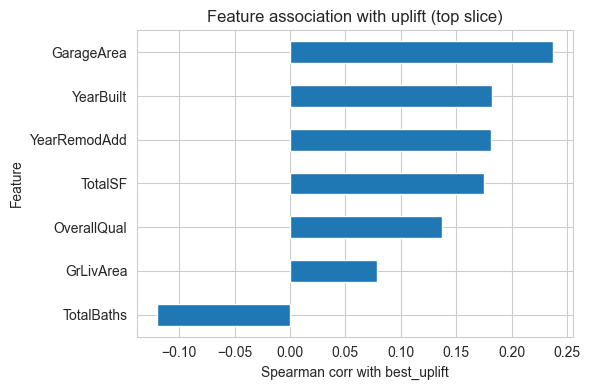

In [251]:
corrs_plot = corrs.head(12).iloc[::-1]  # top 12, bottom-to-top
ax = corrs_plot.plot(kind="barh", figsize=(6,4))
ax.set_xlabel("Spearman corr with best_uplift")
ax.set_ylabel("Feature")
ax.set_title("Feature association with uplift (top slice)")
plt.tight_layout()
plt.show()

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure % uplift exists (safe if already present)
def _ensure_pct_uplift(df):
    if "pct_uplift" not in df.columns:
        df = df.copy()
        base = pd.to_numeric(df["base_pred"], errors="coerce")
        df["pct_uplift"] = df["best_uplift"] / base.replace(0, np.nan)
    return df

def uplift_by_cat(df, col, *, kind="dollar", min_n=5, order=None):
    """
    Summarize uplift by a categorical column.
    kind: 'dollar' uses best_uplift, 'percent' uses pct_uplift
    order: optional list to reindex rows (e.g., ORDINAL_ORDER['KitchenQual'])
    """
    df = _ensure_pct_uplift(df)

    if kind == "dollar":
        series = pd.to_numeric(df["best_uplift"], errors="coerce")
        label_mean, label_median = "mean_uplift_$", "median_uplift_$"
    elif kind == "percent":
        series = pd.to_numeric(df["pct_uplift"], errors="coerce")
        label_mean, label_median = "mean_uplift_pct", "median_uplift_pct"
    else:
        raise ValueError("kind must be 'dollar' or 'percent'")

    g = (
        series.groupby(df[col])
              .agg(["count", "mean", "median"])
              .rename(columns={"count":"n", "mean":label_mean, "median":label_median})
              .reset_index()
    )

    # filter by sample size
    g = g[g["n"] >= min_n]

    # optional reordering by a provided ordinal list
    if order:
        present = [x for x in order if x in g[col].tolist()]
        g = g.set_index(col).reindex(present).reset_index()

    # sort by median uplift (descending) for readability
    g = g.sort_values(label_median, ascending=False, na_position="last").reset_index(drop=True)
    return g

def plot_uplift_by_cat(summary_df, col, *, kind="dollar", top_k=None):
    """
    Bar plot from the summary produced by uplift_by_cat.
    """
    if kind == "dollar":
        ycol = "median_uplift_$"
        xlabel = "Median uplift ($)"
    else:
        ycol = "median_uplift_pct"
        xlabel = "Median uplift (% of base)"

    dfp = summary_df.copy()
    if top_k:
        dfp = dfp.head(top_k)

    # annotate with n
    labels = dfp[col].astype(str) + "  (n=" + dfp["n"].astype(int).astype(str) + ")"

    ax = dfp[ycol].plot(kind="barh", figsize=(7, max(3, 0.4*len(dfp))), x=None)
    ax.set_yticks(range(len(dfp)))
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_title(f"{col}: {xlabel}")
    for i, v in enumerate(dfp[ycol].values):
        if pd.notna(v):
            ax.text(v, i, f" {v:.2f}", va="center")
    plt.tight_layout()
    plt.show()

  KitchenQual    n  mean_uplift_$  median_uplift_$
0          Ex   33   10983.356350     10232.267318
1          Fa   10   10039.150788      9644.174568
2          TA  105    9209.826853      9178.966345
3          Gd  139    9632.090551      8957.500801


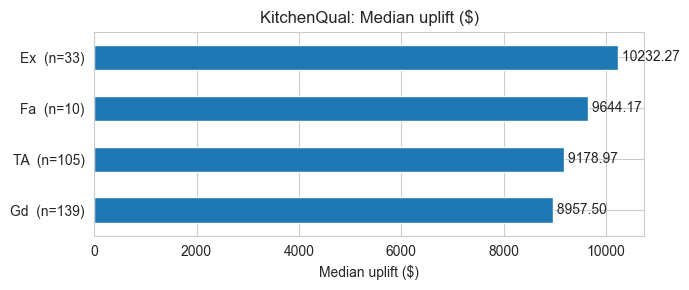

  KitchenQual    n  mean_uplift_pct  median_uplift_pct
0          Fa   10         0.146468           0.161742
1          TA  105         0.064311           0.057681
2          Gd  139         0.036102           0.034179
3          Ex   33         0.034036           0.029650


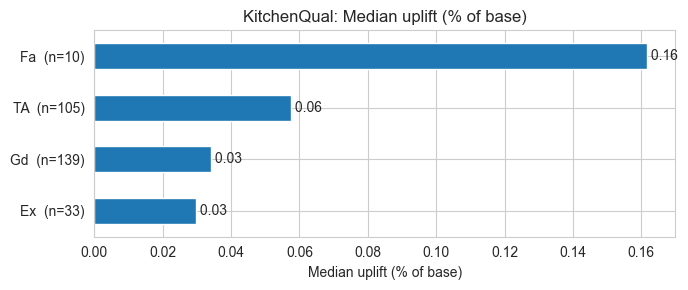

   Neighborhood   n  mean_uplift_$  median_uplift_$
0        Timber  18   11716.053199     11498.682536
1       NridgHt  24   10313.806471     10401.994277
2       SawyerW   9   10016.330283      9783.435003
3       Somerst  42   10209.625953      9674.627695
4        Sawyer  12    9258.494609      9521.601907
5       Edwards   8    9548.867004      9484.066826
6        NWAmes  18    9300.056926      9116.860793
7       Veenker   8   11614.319640      8957.500801
8       BrkSide  39    9088.823934      8838.399543
9       CollgCr  32    9443.499220      8620.397473
10        NAmes  21    8772.658678      8512.009660
11      StoneBr  21    9245.071921      8380.996208
12      NoRidge  17    8709.919466      8168.169784


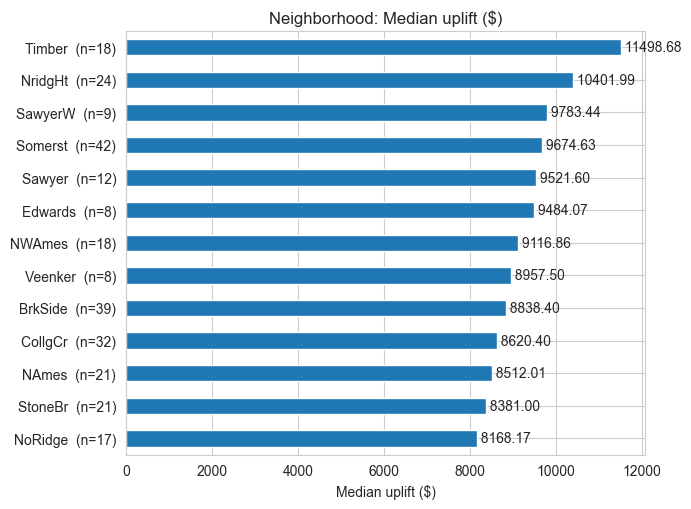

   Neighborhood   n  mean_uplift_pct  median_uplift_pct
0       Edwards   8         0.094623           0.103731
1        Sawyer  12         0.090058           0.075967
2       BrkSide  39         0.078374           0.068130
3         NAmes  21         0.055905           0.057681
4        NWAmes  18         0.046083           0.047287
5       SawyerW   9         0.069727           0.040987
6        Timber  18         0.038614           0.038096
7       Somerst  42         0.038659           0.037219
8       CollgCr  32         0.037062           0.033592
9       Veenker   8         0.035556           0.032934
10      StoneBr  21         0.035208           0.030616
11      NridgHt  24         0.033790           0.029681
12      NoRidge  17         0.028750           0.029052


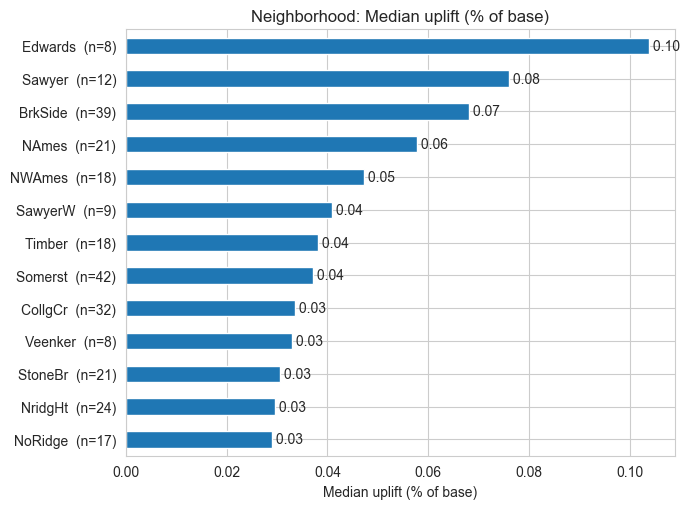

In [248]:
# Example: KitchenQual ($ view), ordered by your ordinal scale
ORDINAL_ORDER = {
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    # ... keep your existing dict here
}

kq_dollar = uplift_by_cat(
    top_ripest, "KitchenQual", kind="dollar",
    min_n=5, order=ORDINAL_ORDER.get("KitchenQual")
)
print(kq_dollar)
plot_uplift_by_cat(kq_dollar, "KitchenQual", kind="dollar")

# Example: KitchenQual (% view)
kq_pct = uplift_by_cat(
    top_ripest, "KitchenQual", kind="percent",
    min_n=5, order=ORDINAL_ORDER.get("KitchenQual")
)
print(kq_pct)
plot_uplift_by_cat(kq_pct, "KitchenQual", kind="percent")

# Neighborhood ($)
nbhd_dollar = uplift_by_cat(top_ripest, "Neighborhood", kind="dollar", min_n=5)
print(nbhd_dollar)
plot_uplift_by_cat(nbhd_dollar, "Neighborhood", kind="dollar", top_k=20)

# Neighborhood (%)
nbhd_pct = uplift_by_cat(top_ripest, "Neighborhood", kind="percent", min_n=5)
print(nbhd_pct)
plot_uplift_by_cat(nbhd_pct, "Neighborhood", kind="percent", top_k=20)

In [258]:
def to_one_row_per_home(df, id_col="_id_", uplift_col="best_uplift"):
    df = df.copy()

    # 1) Resolve duplicated merge columns (_x / _y) for key fields
    def coalesce_pair(base):
        x, y = f"{base}_x", f"{base}_y"
        if x in df.columns:
            df[base] = df[x]
        elif y in df.columns:
            df[base] = df[y]

    for base in ["_id_", "_idx", "y_true", "base_pred", "residual"]:
        if f"{base}_x" in df.columns or f"{base}_y" in df.columns:
            coalesce_pair(base)

    # Drop all *_x / *_y columns
    df = df.loc[:, ~df.columns.str.endswith(("_x", "_y"))]

    # 2) If _id_ is missing but _idx exists, use _idx as id
    if id_col not in df.columns and "_idx" in df.columns:
        id_col = "_idx"

    # 3) Keep one row per home: the row with max best_uplift
    if uplift_col not in df.columns:
        raise ValueError(f"'{uplift_col}' column not found in df.")

    # idx of the max-uplift row for each home
    best_idx = df.groupby(id_col, as_index=False)[uplift_col].idxmax()[uplift_col]

    out = (
        df.loc[best_idx]
          .sort_values(["residual", uplift_col], ascending=[False, False])
          .reset_index(drop=True)
    )

    # Optional: ensure id is clean type
    try:
        out[id_col] = out[id_col].astype(int)
    except Exception:
        out[id_col] = out[id_col].astype(str)

    return out

# Use it:
top_ripest_one = to_one_row_per_home(top_ripest)
print("Unique homes:", top_ripest_one["_id_"].nunique(), "| rows:", len(top_ripest_one))
print(top_ripest_one.head())

Unique homes: 100 | rows: 100
   _id_  _idx    y_true      base_pred      residual   best_uplift  \
0   618   617  392000.0  365022.940092  26977.059908   8168.169784   
1   243  2059  200000.0  179895.726704  20104.273296   8772.898681   
2   213  1212  360000.0  345104.078171  14895.921829  10232.267318   
3    70    69  284500.0  270691.514018  13808.485982   8168.169784   
4   212  2028  350000.0  337893.404885  12106.595115   8619.546015   

   best_new_pred best_feature              best_upgrade Neighborhood MSZoning  \
0  373191.109876  KitchenQual  KitchenQual → best (max)      StoneBr       RL   
1  188668.625385  KitchenQual  KitchenQual → best (max)       NWAmes       RL   
2  355336.345489   TotalBaths           TotalBaths +1.0      NridgHt       RL   
3  278859.683803  KitchenQual  KitchenQual → best (max)      NoRidge       RL   
4  346512.950900  KitchenQual  KitchenQual → best (max)      NoRidge       RL   

  KitchenQual  OverallQual  TotalBaths  YearBuilt  YearRemodAd

In [262]:
top_ripest_one

,_id_,_idx,y_true,base_pred,residual,best_uplift,best_new_pred,best_feature,best_upgrade,Neighborhood,MSZoning,KitchenQual,OverallQual,TotalBaths,YearBuilt,YearRemodAdd,GarageArea,GrLivArea,TotalSF
0,618,617,392000.0,365022.940092,26977.059908,8168.169784,373191.109876,KitchenQual,KitchenQual → best (max),StoneBr,RL,Gd,8.0,3.2,2007.0,2007.0,567.0,1419,2838.0
1,243,2059,200000.0,179895.726704,20104.273296,8772.898681,188668.625385,KitchenQual,KitchenQual → best (max),NWAmes,RL,TA,6.0,2.0,1978.0,1986.0,650.0,2464,4882.0
2,213,1212,360000.0,345104.078171,14895.921829,10232.267318,355336.345489,TotalBaths,TotalBaths +1.0,NridgHt,RL,Ex,9.0,2.0,2008.0,2008.0,505.0,1505,3010.0
3,70,69,284500.0,270691.514018,13808.485982,8168.169784,278859.683803,KitchenQual,KitchenQual → best (max),NoRidge,RL,Gd,8.0,2.5,1997.0,1997.0,516.0,2199,3372.0
4,212,2028,350000.0,337893.404885,12106.595115,8619.546015,346512.950900,KitchenQual,KitchenQual → best (max),NoRidge,RL,Gd,8.0,2.5,1995.0,1995.0,480.0,1200,1800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,363,1362,89500.0,86164.986614,3335.013386,9213.137661,95378.124275,KitchenQual,KitchenQual → best (max),BrDale,RM,TA,6.0,1.5,1971.0,1971.0,400.0,1474,1858.0
96,518,1517,180000.0,176778.809240,3221.190760,8230.245554,185009.054794,KitchenQual,KitchenQual → best (max),Sawyer,RL,TA,5.0,2.5,1968.0,1993.0,432.0,964,1840.0
97,784,783,324000.0,320852.579990,3147.420010,8433.836689,329286.416679,ExterQual,ExterQual → best (max),Veenker,RL,Gd,8.0,3.9,1993.0,1993.0,473.0,1719,3438.0
98,185,184,249700.0,246640.588721,3059.411279,11398.281398,258038.870119,TotalBaths,TotalBaths +1.0,Somerst,FV,Gd,8.0,2.0,2006.0,2006.0,826.0,1656,3312.0


In [265]:
import numpy as np
import pandas as pd

def global_upgrade_ranking(upgrades_long: pd.DataFrame, min_n: int = 5) -> pd.DataFrame:
    """
    Rank upgrades globally by median uplift (dollars), show IQR bands and % view.
    Expects `upgrades_long` to have columns: ['upgrade','uplift','pct_uplift'].
    """
    if "pct_uplift" not in upgrades_long.columns:
        # create if missing
        upgrades_long = upgrades_long.copy()
        upgrades_long["pct_uplift"] = upgrades_long["uplift"] / upgrades_long["base_pred"]

    stats = (
        upgrades_long
        .groupby("upgrade", dropna=False)
        .agg(
            n=("uplift", "count"),
            median_dollar=("uplift", "median"),
            q25_dollar=("uplift", lambda x: np.percentile(x, 25)),
            q75_dollar=("uplift", lambda x: np.percentile(x, 75)),
            median_pct=("pct_uplift", "median"),
            q25_pct=("pct_uplift", lambda x: np.percentile(x, 25)),
            q75_pct=("pct_uplift", lambda x: np.percentile(x, 75)),
        )
        .reset_index()
    )

    # helpful spread metrics
    stats["iqr_dollar"] = stats["q75_dollar"] - stats["q25_dollar"]
    stats["iqr_pct"]    = stats["q75_pct"]    - stats["q25_pct"]

    # filter for stability
    stats = stats[stats["n"] >= min_n].copy()

    # rank by “high median, low variance (IQR)”
    stats["rank_dollar"] = (-stats["median_dollar"] + 0.001 * stats["iqr_dollar"]).rank(method="dense")
    stats["rank_pct"]    = (-stats["median_pct"]    + 0.001 * stats["iqr_pct"]).rank(method="dense")

    # nice ordering for presentation (best $ first)
    stats = stats.sort_values(["median_dollar", "iqr_dollar"], ascending=[False, True], ignore_index=True)
    return stats

In [266]:
def neighborhood_playbook_table(
    upgrades_long_ctx: pd.DataFrame,
    min_n: int = 5,
    top_k: int = 3,
    metric: str = "pct",   # "pct" or "dollar"
) -> pd.DataFrame:
    """
    For each Neighborhood, pick the top-K upgrades by mean uplift
    (either % or $), with sample-count filter per neighborhood×upgrade.

    Expects columns:
      ['Neighborhood','upgrade','uplift','base_pred','pct_uplift']
    """
    df = upgrades_long_ctx.copy()

    if "pct_uplift" not in df.columns:
        df["pct_uplift"] = df["uplift"] / df["base_pred"]

    value_col = "pct_uplift" if metric == "pct" else "uplift"

    agg = (
        df.groupby(["Neighborhood", "upgrade"], dropna=False)
          .agg(
              n=("uplift", "count"),
              mean_dollar=("uplift", "mean"),
              median_dollar=("uplift", "median"),
              mean_pct=("pct_uplift", "mean"),
              median_pct=("pct_uplift", "median"),
          )
          .reset_index()
    )

    # apply min_n per cell
    agg = agg[agg["n"] >= min_n].copy()

    # choose sorting key
    sort_col = "mean_pct" if metric == "pct" else "mean_dollar"

    # take top-K per neighborhood
    agg["rank_in_nbhd"] = agg.groupby("Neighborhood")[sort_col].rank(ascending=False, method="first")
    topk = (
        agg.loc[agg["rank_in_nbhd"] <= top_k]
           .sort_values(["Neighborhood", sort_col], ascending=[True, False], ignore_index=True)
    )

    # a compact presentation table
    # (e.g., Neighborhood | Upgrade | n | mean_$ | median_$ | mean_% | median_%)
    cols = [
        "Neighborhood", "upgrade", "n",
        "mean_dollar", "median_dollar",
        "mean_pct", "median_pct"
    ]
    return topk[cols]

In [267]:
import matplotlib.pyplot as plt

def plot_global_upgrade_ranking(stats: pd.DataFrame, top_k: int = 10):
    show = stats.head(top_k).copy()
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.barh(show["upgrade"], show["median_dollar"], xerr=(show["iqr_dollar"]/2), alpha=0.9)
    ax.invert_yaxis()
    ax.set_xlabel("Median uplift ($)  (error bar ~ IQR/2)")
    ax.set_title("Global upgrade ranking (top median $, lower is better spread)")
    plt.tight_layout()
    plt.show()

def plot_playbook_table(playbook: pd.DataFrame, metric: str = "pct"):
    # simple styled print; for slides you’ll likely paste the DataFrame or export to CSV
    cols = ["Neighborhood", "upgrade", "n",
            "mean_dollar", "median_dollar",
            "mean_pct", "median_pct"]
    display_cols = [c for c in cols if c in playbook.columns]
    print(playbook[display_cols].to_string(index=False))

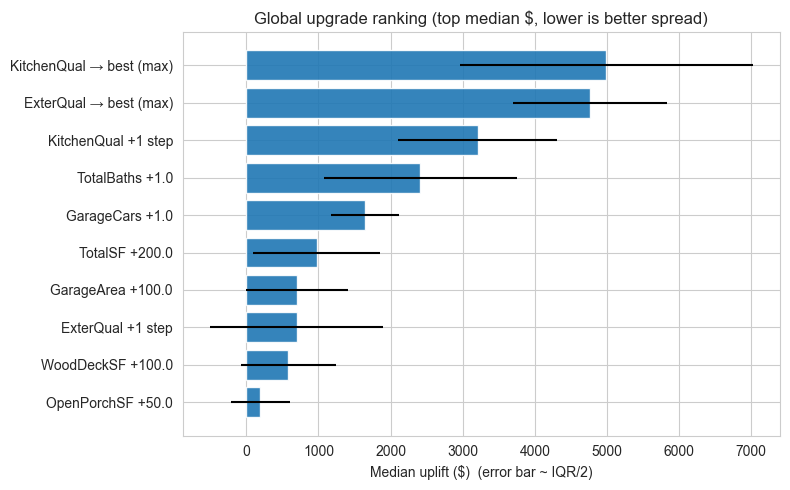

,upgrade,n,median_dollar,q25_dollar,q75_dollar,median_pct,q25_pct,q75_pct,iqr_dollar,iqr_pct,rank_dollar,rank_pct
0,KitchenQual → best (max),774,4989.780616,2219.659054,6283.379227,0.029958,0.010781,0.044058,4063.720173,0.033277,1.0,1.0
1,ExterQual → best (max),774,4762.920210,3530.777063,5659.056115,0.027770,0.017759,0.038457,2128.279051,0.020698,2.0,2.0
2,KitchenQual +1 step,774,3206.145084,1953.385389,4149.638255,0.018971,0.009103,0.027542,2196.252866,0.018439,3.0,3.0
3,TotalBaths +1.0,774,2412.750687,925.512668,3599.497337,0.013088,0.005624,0.021742,2673.984669,0.016118,4.0,4.0
4,GarageCars +1.0,774,1644.226366,1194.054694,2138.446774,0.010325,0.007027,0.012877,944.392080,0.005850,5.0,5.0
5,TotalSF +200.0,774,974.075521,241.703961,2007.757889,0.005948,0.001230,0.012174,1766.053928,0.010944,6.0,7.0
6,GarageArea +100.0,774,702.887529,0.000000,1412.235644,0.004039,0.000000,0.008180,1412.235644,0.008180,7.0,8.0
7,ExterQual +1 step,774,697.505399,697.505399,3103.726897,0.006401,0.004486,0.014630,2406.221498,0.010144,8.0,6.0
8,WoodDeckSF +100.0,774,582.776794,183.633311,1493.448899,0.003948,0.001060,0.008804,1309.815588,0.007744,9.0,9.0
9,OpenPorchSF +50.0,774,196.251273,-154.852595,652.454560,0.001185,-0.001029,0.003867,807.307155,0.004896,10.0,10.0


In [268]:
# 1) Global upgrade ranking
upgrade_stats = global_upgrade_ranking(upgrades_long_ctx, min_n=5)
plot_global_upgrade_ranking(upgrade_stats, top_k=10)
upgrade_stats.head(10)

In [269]:
# 2) Neighborhood playbook
playbook_pct = neighborhood_playbook_table(upgrades_long_ctx, min_n=5, top_k=3, metric="pct")
print("\nPlaybook (percent view):")
plot_playbook_table(playbook_pct, metric="pct")

playbook_dollar = neighborhood_playbook_table(upgrades_long_ctx, min_n=5, top_k=3, metric="dollar")
print("\nPlaybook (dollar view):")
plot_playbook_table(playbook_dollar, metric="dollar")


Playbook (percent view):
Neighborhood                  upgrade   n  mean_dollar  median_dollar  mean_pct  median_pct
     Blmngtn   ExterQual → best (max)  10  4189.575377    4251.547226  0.026569    0.024657
     Blmngtn KitchenQual → best (max)  10  3067.100677    3066.130768  0.022025    0.012827
     Blmngtn        ExterQual +1 step  10  3221.892627    3299.630558  0.016833    0.014043
     BrkSide KitchenQual → best (max)  34  6416.490123    5859.416701  0.052403    0.043133
     BrkSide   ExterQual → best (max)  34  4860.926941    4985.882772  0.038945    0.035511
     BrkSide      KitchenQual +1 step  34  3805.477762    3863.162373  0.026951    0.025614
     ClearCr KitchenQual → best (max)   9  6219.859996    5910.106673  0.043594    0.037367
     ClearCr   ExterQual → best (max)   9  4238.451402    4923.317463  0.030886    0.031905
     ClearCr      KitchenQual +1 step   9  3570.681459    3924.123899  0.021203    0.028354
     CollgCr KitchenQual → best (max)  65  4529.316446

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# ---------- helpers ----------
def _pct(uplift, base):
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(np.abs(base) < 1e-9, np.nan, uplift/base)

def _fmt_money(x): return f"${x:,.0f}"
def _fmt_pct(x):    return f"{x:.0%}"

# ---------- 1) Upgrade playbook ----------
def make_upgrade_playbook(upgrades_long_ctx, min_n=20, order=None):
    df = upgrades_long_ctx.copy()
    df["pct_uplift"] = _pct(df["uplift"], df["base_pred"])

    def iqr(a): 
        a = np.asarray(a, dtype=float)
        return np.nanpercentile(a, 75) - np.nanpercentile(a, 25)

    g = (df.groupby("upgrade")
          .agg(n=("uplift","count"),
               median_dollar=("uplift","median"),
               iqr_dollar=("uplift", iqr),
               median_pct=("pct_uplift","median"),
               iqr_pct=("pct_uplift", iqr))
          .reset_index())

    g = g[g["n"] >= min_n].copy()
    # stability scores (lower is better): negative median (so higher median ranks earlier) + spread
    g["rank_dollar"] = (-g["median_dollar"]).rank(method="first") + g["iqr_dollar"].rank(method="first")
    g["rank_pct"]    = (-g["median_pct"]).rank(method="first")    + g["iqr_pct"].rank(method="first")

    if order:
        pos = {u:i for i,u in enumerate(order)}
        g["__ord"] = g["upgrade"].map(pos)
        g = g.sort_values(["__ord","rank_dollar"], na_position="last").drop(columns="__ord")
    else:
        g = g.sort_values("rank_dollar")

    return g[["upgrade","n","median_dollar","iqr_dollar","median_pct","iqr_pct","rank_dollar","rank_pct"]]

def plot_upgrade_playbook(g, kind="dollar"):
    if kind=="dollar":
        x = "median_dollar"; title="Upgrades — median uplift ($)"; color="#2b8cbe"; fmt=_fmt_money
    else:
        x = "median_pct";    title="Upgrades — median uplift (% of base)"; color="#3c8c6e"; fmt=_fmt_pct

    show = g.sort_values(x, ascending=True)
    plt.figure(figsize=(12, 0.5*len(show)+2))
    ax = sns.barplot(data=show, y="upgrade", x=x, color=color)
    ax.set_title(title); ax.set_xlabel(x.replace("_"," ").title()); ax.set_ylabel("")
    xmax = float(np.nanmax(show[x])) if len(show) else 1.0
    ax.set_xlim(0, xmax*1.08)
    for i, v in enumerate(show[x]):
        ax.text(v*(1.002 if v>=0 else 0.998), i, f" {fmt(v)}", va="center")
    plt.tight_layout(); plt.show()

# ---------- 2) Neighborhood hotspots ----------
def make_neighborhood_hotspots(upgrades_long_ctx, min_n=8, top_k_upgrades=3, sort_by="median_dollar"):
    df = upgrades_long_ctx.copy()
    df["pct_uplift"] = _pct(df["uplift"], df["base_pred"])

    agg = (df.groupby("Neighborhood")
             .agg(n_total=("uplift","count"),
                  median_dollar=("uplift","median"),
                  mean_dollar=("uplift","mean"),
                  median_pct=("pct_uplift","median"),
                  mean_pct=("pct_uplift","mean"))
             .reset_index())

    agg = agg[agg["n_total"] >= min_n].copy()

    # Top upgrades per neighborhood (by mean $ uplift) - DO NOT explode strings
    upg = (df.groupby(["Neighborhood","upgrade"])["uplift"]
             .mean()
             .reset_index()
             .merge(agg[["Neighborhood"]], on="Neighborhood", how="inner"))

    upg["rk"] = upg.groupby("Neighborhood")["uplift"].rank(method="first", ascending=False)
    top_upg = (upg[upg["rk"] <= top_k_upgrades]
               .sort_values(["Neighborhood","rk"])
               .groupby("Neighborhood")["upgrade"]
               .apply(lambda s: ", ".join(list(s.astype(str))))
               .reset_index()
               .rename(columns={"upgrade":"Top Upgrades"}))

    out = agg.merge(top_upg, on="Neighborhood", how="left")
    out = out.sort_values(sort_by, ascending=False, ignore_index=True)
    return out

def plot_neighborhood_hotspots_bar(nb_df, by="dollar", top_k=12):
    if by=="dollar":
        col="median_dollar"; title="Neighborhood — median uplift ($)"; color="#7986cb"; fmt=_fmt_money
    else:
        col="median_pct";    title="Neighborhood — median uplift (% of base)"; color="#64b5f6"; fmt=_fmt_pct

    show = nb_df.head(top_k).sort_values(col, ascending=True)
    plt.figure(figsize=(12, 0.45*len(show)+2))
    ax = sns.barplot(data=show, y="Neighborhood", x=col, color=color)
    ax.set_title(title); ax.set_xlabel(""); ax.set_ylabel("")
    xmax = float(np.nanmax(show[col])) if len(show) else 1.0
    ax.set_xlim(0, xmax*1.10)
    for i, v in enumerate(show[col]):
        ax.text(v*(1.002 if v>=0 else 0.998), i, f" {fmt(v)}", va="center")
    plt.tight_layout(); plt.show()

# ---------- 3) Target profile ----------
def make_target_profile(compare_tbl):
    df = compare_tbl.copy()
    df["Pct_diff"] = (df["Top_mean"] - df["Rest_mean"]) / df["Rest_mean"]
    return df[["feature","Top_mean","Rest_mean","Pct_diff"]]

def plot_target_profile(compare_tbl):
    df = compare_tbl.copy().sort_values("Pct_diff", ascending=True)
    plt.figure(figsize=(8, 0.55*len(df)+2))
    ax = sns.barplot(data=df, y="feature", x="Pct_diff", color="#636efa")
    ax.set_title("Top slice vs Rest — relative difference")
    ax.set_xlabel("Relative difference (Top − Rest) / Rest")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,_: f"{x:.0%}"))
    for i, v in enumerate(df["Pct_diff"]):
        ax.text(v*(1.002 if v>=0 else 0.998), i, f" {v:.0%}", va="center")
    plt.tight_layout(); plt.show()

,upgrade,n,median_dollar,iqr_dollar,median_pct,iqr_pct,rank_dollar,rank_pct
2,ExterQual → best (max),774,4762.920210,2128.279051,0.027770,0.020698,10.0,13.0
6,KitchenQual → best (max),774,4989.780616,4063.720173,0.029958,0.033277,13.0,13.0
1,ExterQual +1 step,774,697.505399,2406.221498,0.006401,0.010144,18.0,13.0
5,KitchenQual +1 step,774,3206.145084,2196.252866,0.018971,0.018439,12.0,13.0
4,GarageCars +1.0,774,1644.226366,944.392080,0.010325,0.005850,9.0,9.0
9,TotalBaths +1.0,774,2412.750687,2673.984669,0.013088,0.016118,15.0,13.0
10,TotalSF +200.0,774,974.075521,1766.053928,0.005948,0.010944,13.0,15.0
11,WoodDeckSF +100.0,774,582.776794,1309.815588,0.003948,0.007744,14.0,14.0
3,GarageArea +100.0,774,702.887529,1412.235644,0.004039,0.008180,13.0,14.0
7,OpenPorchSF +50.0,774,196.251273,807.307155,0.001185,0.004896,13.0,13.0


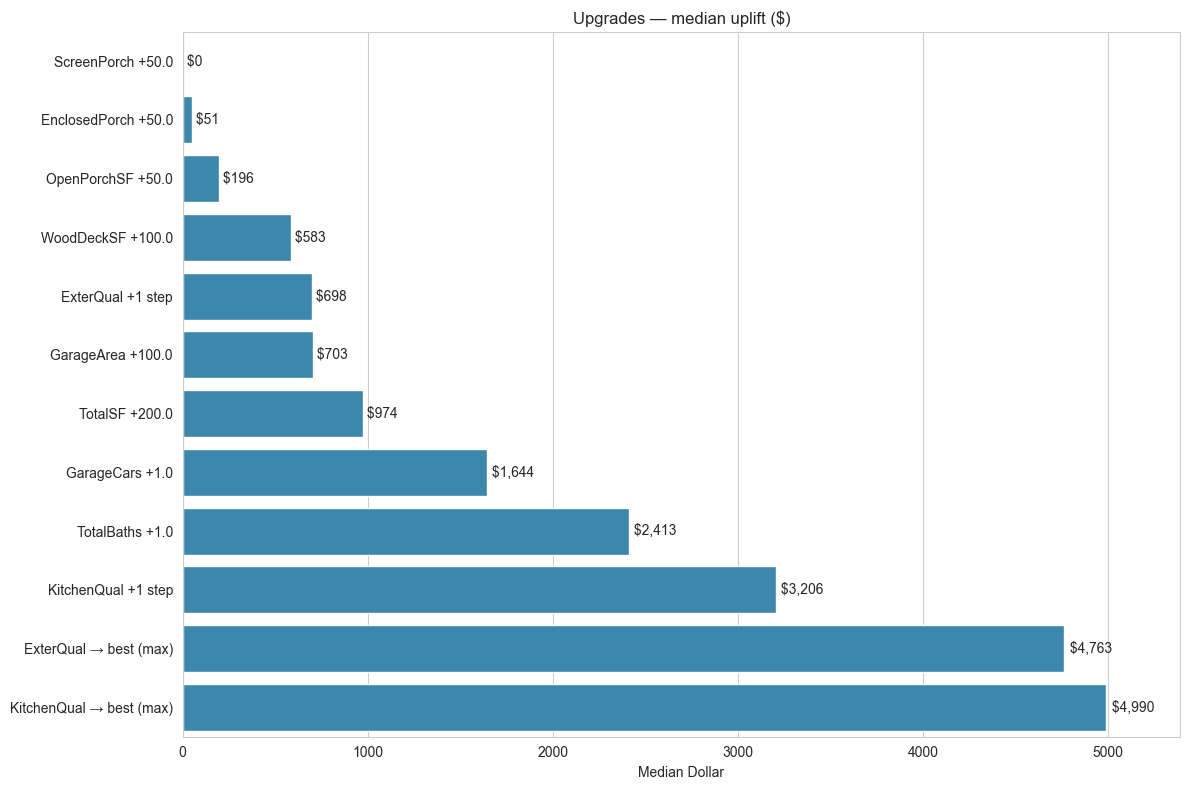

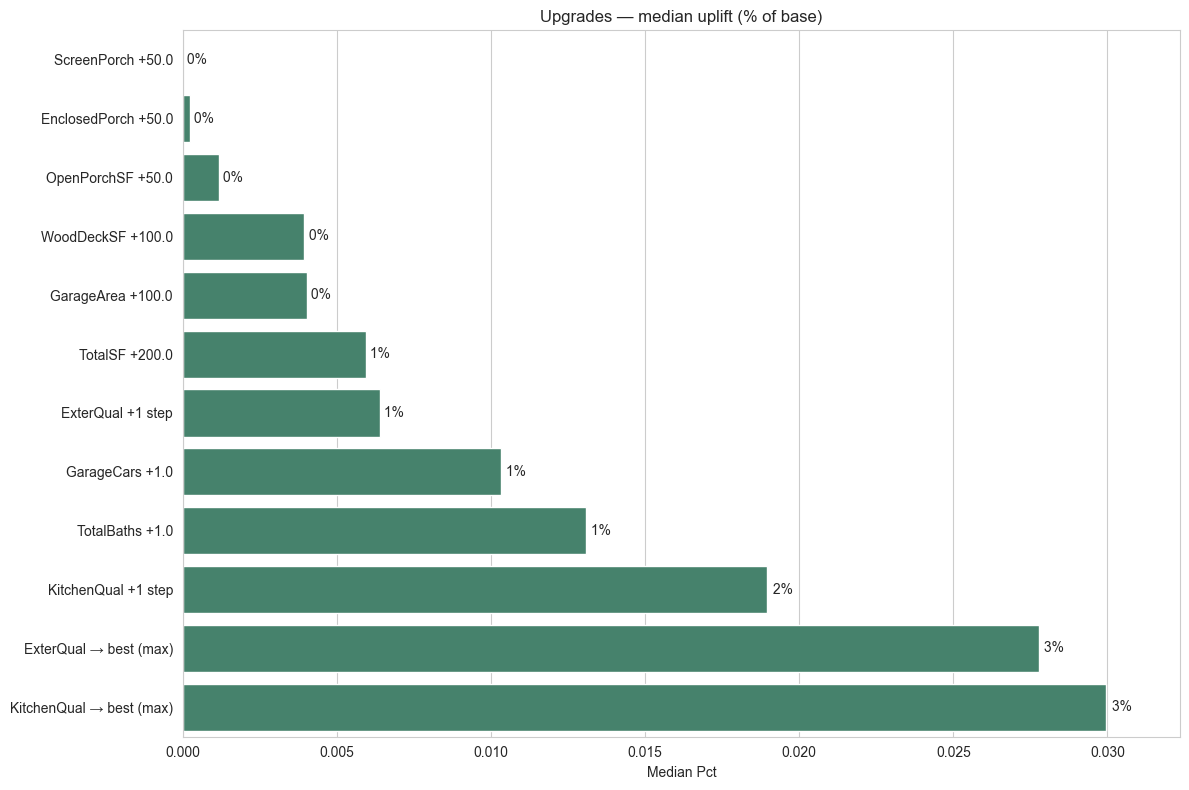

,Neighborhood,n_total,median_dollar,mean_dollar,median_pct,mean_pct,Top Upgrades
0,Greens,60,1503.656901,2083.927205,0.007650,0.012926,"ExterQual → best (max), KitchenQual → best (ma..."
1,Blueste,36,1378.509019,1864.974218,0.009943,0.012612,"KitchenQual → best (max), ExterQual → best (ma..."
2,NPkVill,24,1280.937889,1864.136625,0.010540,0.013159,"KitchenQual → best (max), ExterQual → best (ma..."
3,NWAmes,468,1280.886543,1821.500861,0.006909,0.010964,"ExterQual → best (max), KitchenQual → best (ma..."
4,CollgCr,780,1268.785611,1905.646976,0.007135,0.011841,"ExterQual → best (max), KitchenQual → best (ma..."
5,Blmngtn,120,1208.559405,1615.984430,0.007402,0.010319,"ExterQual → best (max), ExterQual +1 step, Kit..."
6,MeadowV,96,1204.321743,1807.749762,0.009354,0.016929,"KitchenQual → best (max), ExterQual → best (ma..."
7,SawyerW,372,1181.972748,1781.696654,0.006314,0.009090,"ExterQual → best (max), KitchenQual → best (ma..."
8,OldTown,648,1174.868603,1929.336325,0.007163,0.012185,"KitchenQual → best (max), ExterQual → best (ma..."
9,Sawyer,540,1095.668766,1901.677146,0.006958,0.012953,"KitchenQual → best (max), ExterQual → best (ma..."


,Neighborhood,n_total,median_dollar,mean_dollar,median_pct,mean_pct,Top Upgrades
0,NPkVill,24,1280.937889,1864.136625,0.010540,0.013159,"KitchenQual → best (max), ExterQual → best (ma..."
1,Blueste,36,1378.509019,1864.974218,0.009943,0.012612,"KitchenQual → best (max), ExterQual → best (ma..."
2,MeadowV,96,1204.321743,1807.749762,0.009354,0.016929,"KitchenQual → best (max), ExterQual → best (ma..."
3,Greens,60,1503.656901,2083.927205,0.007650,0.012926,"ExterQual → best (max), KitchenQual → best (ma..."
4,BrkSide,408,1023.756206,1934.928616,0.007455,0.014585,"KitchenQual → best (max), ExterQual → best (ma..."
5,Blmngtn,120,1208.559405,1615.984430,0.007402,0.010319,"ExterQual → best (max), ExterQual +1 step, Kit..."
6,OldTown,648,1174.868603,1929.336325,0.007163,0.012185,"KitchenQual → best (max), ExterQual → best (ma..."
7,Veenker,72,1086.041763,1872.918022,0.007160,0.012349,"KitchenQual → best (max), ExterQual → best (ma..."
8,CollgCr,780,1268.785611,1905.646976,0.007135,0.011841,"ExterQual → best (max), KitchenQual → best (ma..."
9,IDOTRR,252,802.485843,1784.990225,0.006999,0.016260,"KitchenQual → best (max), ExterQual → best (ma..."


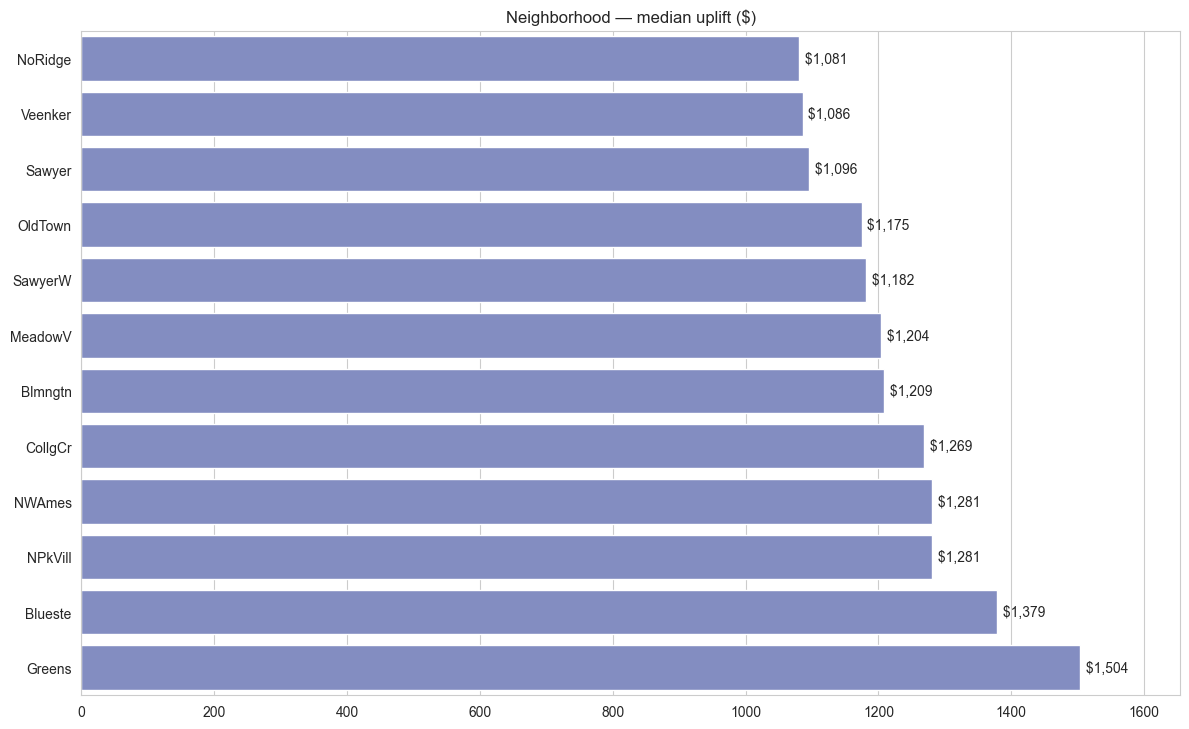

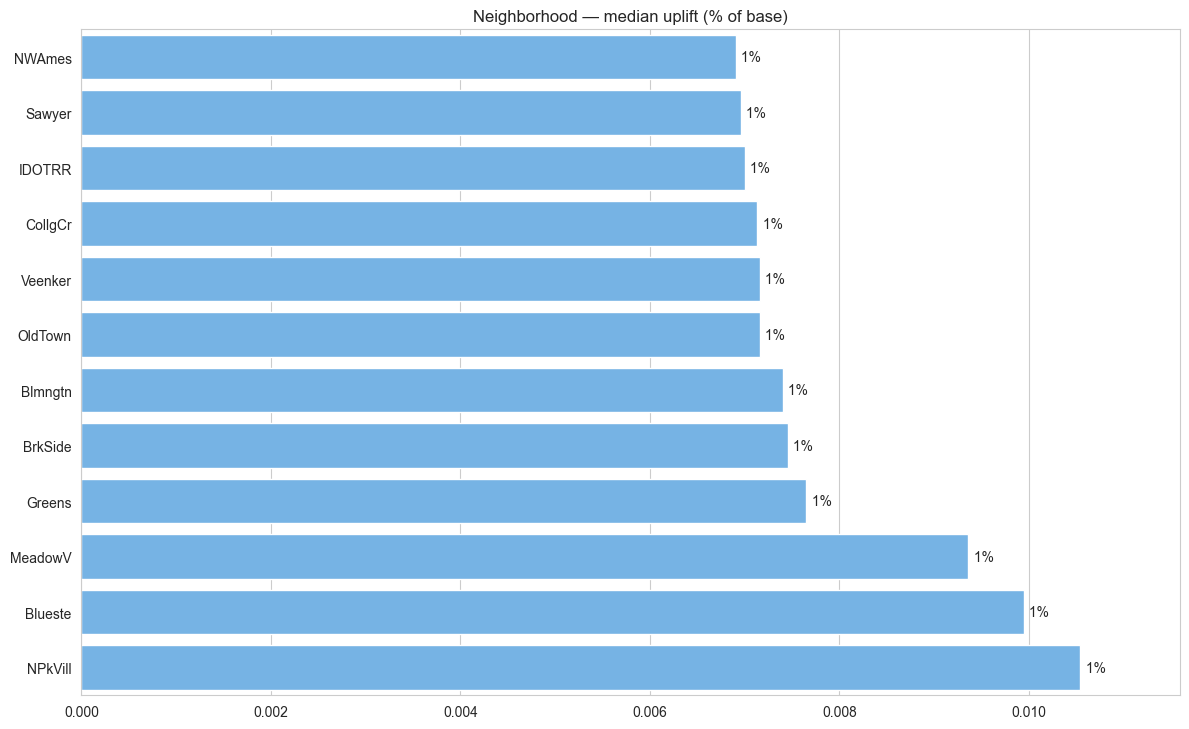

,feature,Top_mean,Rest_mean,Pct_diff
0,TotalSF,3061.640,2442.135699,0.253673
1,GarageArea,553.550,449.918580,0.230334
2,GrLivArea,1720.550,1439.469729,0.195267
3,OverallQual,6.870,5.931106,0.158300
4,TotalBaths,2.502,2.243633,0.115156
5,YearRemodAdd,1989.810,1981.795407,0.004044
6,YearBuilt,1978.140,1970.551148,0.003851


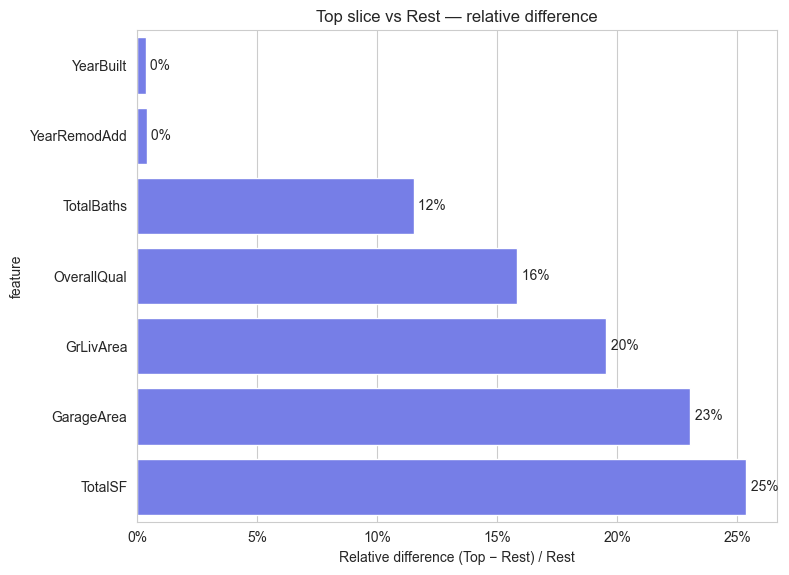

In [274]:
UPGRADE_ORDER = [
    "ExterQual → best (max)", "KitchenQual → best (max)",
    "ExterQual +1 step", "KitchenQual +1 step",
    "GarageCars +1.0", "TotalBaths +1.0",
    "TotalSF +200.0", "WoodDeckSF +100.0",
    "GarageArea +100.0", "OpenPorchSF +50.0",
    "ScreenPorch +50.0", "EnclosedPorch +50.0",
]

# 1) Upgrade playbook
upg_play = make_upgrade_playbook(upgrades_long_ctx, min_n=20, order=UPGRADE_ORDER)
display(upg_play)                  # tidy table
plot_upgrade_playbook(upg_play, "dollar")
plot_upgrade_playbook(upg_play, "percent")

# 2) Neighborhood hotspots (table + plots)
nb_table_dollar  = make_neighborhood_hotspots(upgrades_long_ctx, min_n=8, top_k_upgrades=3, sort_by="median_dollar")
nb_table_percent = make_neighborhood_hotspots(upgrades_long_ctx, min_n=8, top_k_upgrades=3, sort_by="median_pct")
display(nb_table_dollar.head(12))
display(nb_table_percent.head(12))
plot_neighborhood_hotspots_bar(nb_table_dollar,  by="dollar",  top_k=12)
plot_neighborhood_hotspots_bar(nb_table_percent, by="percent", top_k=12)

# 3) Target profile (rebuild compare_tbl from the numbers you printed)
compare_tbl = pd.DataFrame({
    "feature":["TotalSF","GarageArea","GrLivArea","OverallQual","TotalBaths","YearRemodAdd","YearBuilt"],
    "Top_mean":[3061.640,553.550,1720.550,6.870,2.502,1989.810,1978.140],
    "Rest_mean":[2442.135699,449.918580,1439.469729,5.931106,2.243633,1981.795407,1970.551148],
})
tp = make_target_profile(compare_tbl)
display(tp)
plot_target_profile(tp)

In [275]:
# === HEATMAPS (Upgrades vs Neighborhoods) ===

def make_heatmaps(upgrades_long_ctx, min_n=8, top_upgrades=None, top_neighborhoods=None):
    df = upgrades_long_ctx.copy()
    df["pct_uplift"] = _pct(df["uplift"], df["base_pred"])

    # filter: only neighborhoods with at least min_n samples
    valid_nbhd = df["Neighborhood"].value_counts()
    valid_nbhd = valid_nbhd[valid_nbhd >= min_n].index
    df = df[df["Neighborhood"].isin(valid_nbhd)]

    # median $ uplift
    mat_dollar = (df.groupby(["Neighborhood","upgrade"])["uplift"]
                    .median().unstack(fill_value=np.nan))

    # median % uplift
    mat_percent = (df.groupby(["Neighborhood","upgrade"])["pct_uplift"]
                    .median().unstack(fill_value=np.nan))

    # --- optional filter to keep only top_k ---
    if top_upgrades:
        mat_dollar = mat_dollar[top_upgrades]
        mat_percent = mat_percent[top_upgrades]
    if top_neighborhoods:
        mat_dollar = mat_dollar.loc[top_neighborhoods]
        mat_percent = mat_percent.loc[top_neighborhoods]

    return mat_dollar, mat_percent

def plot_heatmaps(mat_dollar, mat_percent, title_suffix=""):
    fig, axes = plt.subplots(1, 2, figsize=(18, 0.5*len(mat_dollar)+4), sharey=True)

    sns.heatmap(mat_dollar, cmap="Blues", annot=True, fmt=".0f", cbar_kws={"label":"Median $ uplift"},
                ax=axes[0], linewidths=0.5, linecolor="grey")
    axes[0].set_title(f"Median $ uplift {title_suffix}")

    sns.heatmap(mat_percent, cmap="Greens", annot=True, fmt=".1%", cbar_kws={"label":"Median % uplift"},
                ax=axes[1], linewidths=0.5, linecolor="grey")
    axes[1].set_title(f"Median % uplift {title_suffix}")

    plt.tight_layout()
    plt.show()

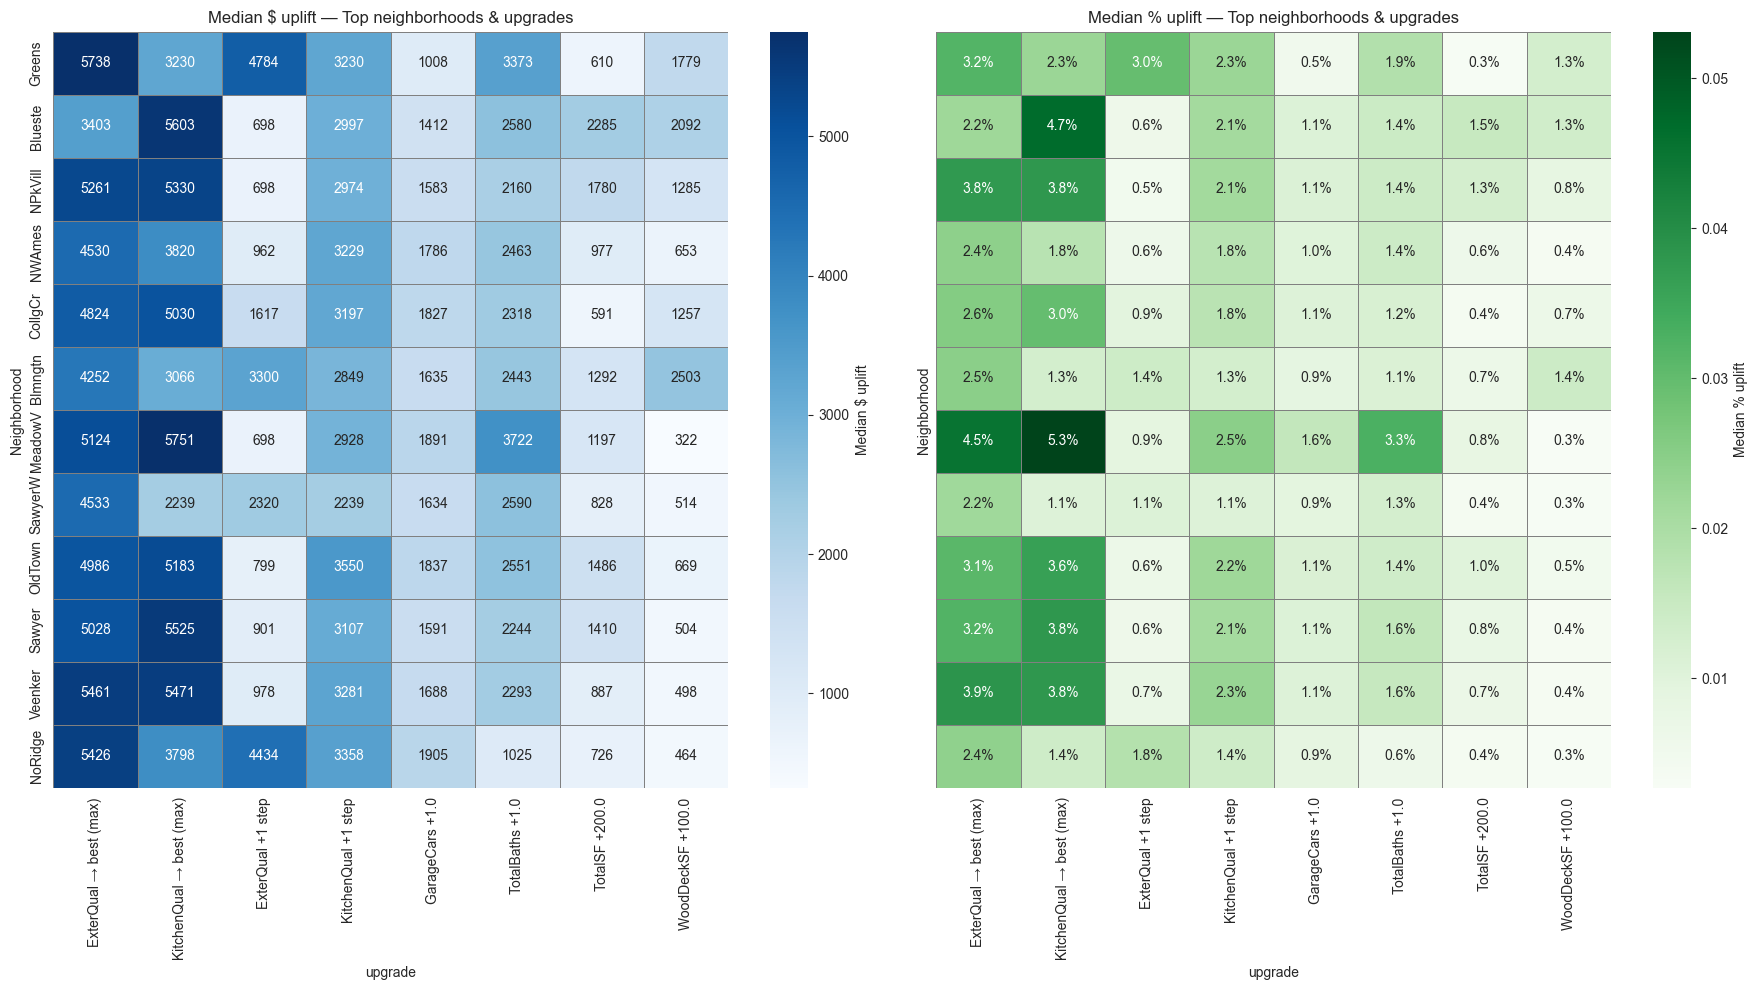

In [278]:
# Pick top neighborhoods and upgrades by medians
nb_table = make_neighborhood_hotspots(upgrades_long_ctx, min_n=8)
top_neighborhoods = nb_table.head(12)["Neighborhood"].tolist()

upg_play = make_upgrade_playbook(upgrades_long_ctx, min_n=20, order=UPGRADE_ORDER)
top_upgrades = upg_play.head(8)["upgrade"].tolist()

# Build matrices
mat_dollar, mat_percent = make_heatmaps(upgrades_long_ctx,
                                        min_n=8,
                                        top_upgrades=top_upgrades,
                                        top_neighborhoods=top_neighborhoods)

# Plot 2x heatmaps: ($ vs %) by neighborhood × upgrade
plot_heatmaps(mat_dollar, mat_percent, title_suffix="— Top neighborhoods & upgrades")

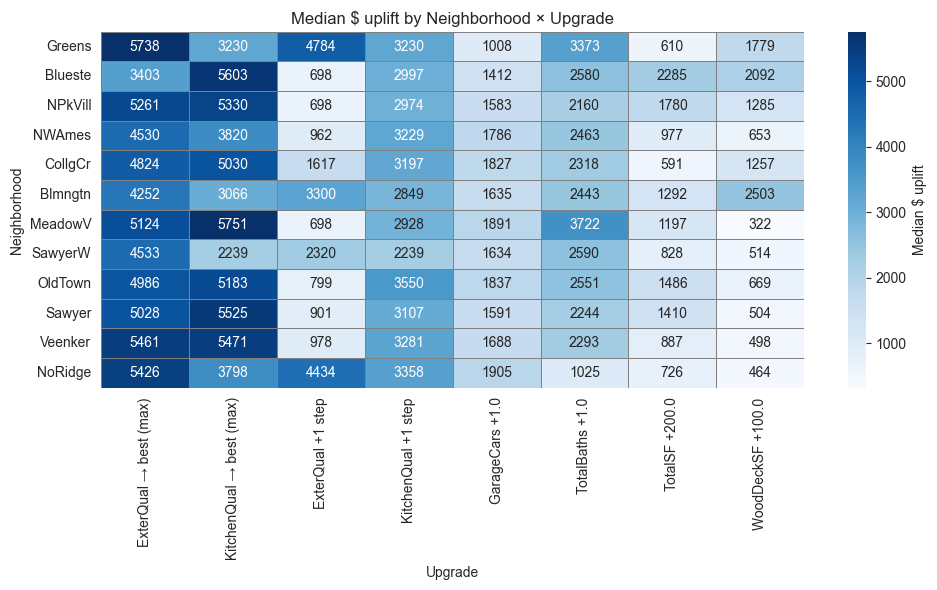

In [279]:
# --- Heatmap: Median $ uplift ---
plt.figure(figsize=(10, 6))
sns.heatmap(mat_dollar, cmap="Blues", annot=True, fmt=".0f",
            linewidths=0.5, linecolor="grey", cbar_kws={"label": "Median $ uplift"})
plt.title("Median $ uplift by Neighborhood × Upgrade")
plt.xlabel("Upgrade")
plt.ylabel("Neighborhood")
plt.tight_layout()
plt.show()

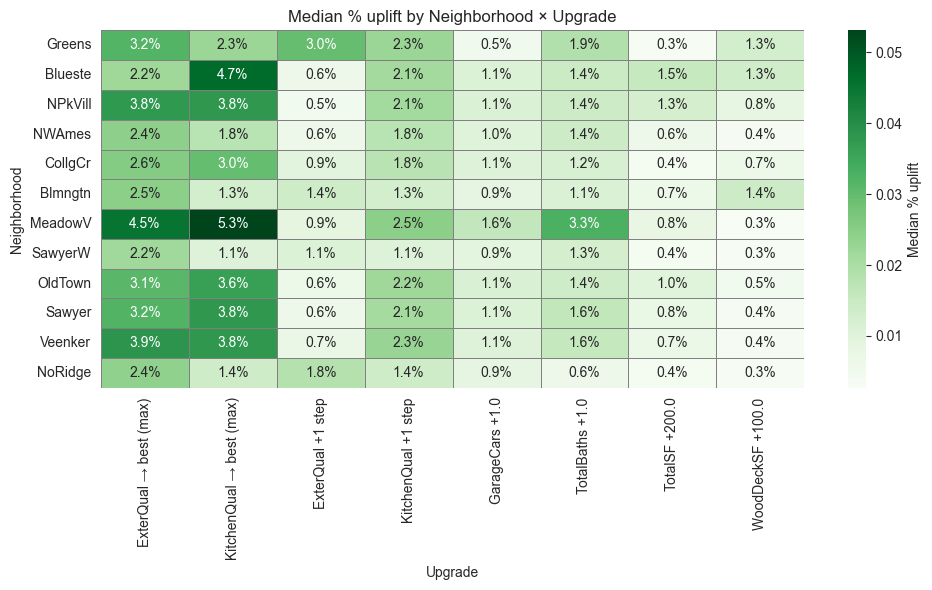

In [280]:
# --- Heatmap: Median % uplift ---
plt.figure(figsize=(10, 6))
sns.heatmap(mat_percent, cmap="Greens", annot=True, fmt=".1%",
            linewidths=0.5, linecolor="grey", cbar_kws={"label": "Median % uplift"})
plt.title("Median % uplift by Neighborhood × Upgrade")
plt.xlabel("Upgrade")
plt.ylabel("Neighborhood")
plt.tight_layout()
plt.show()

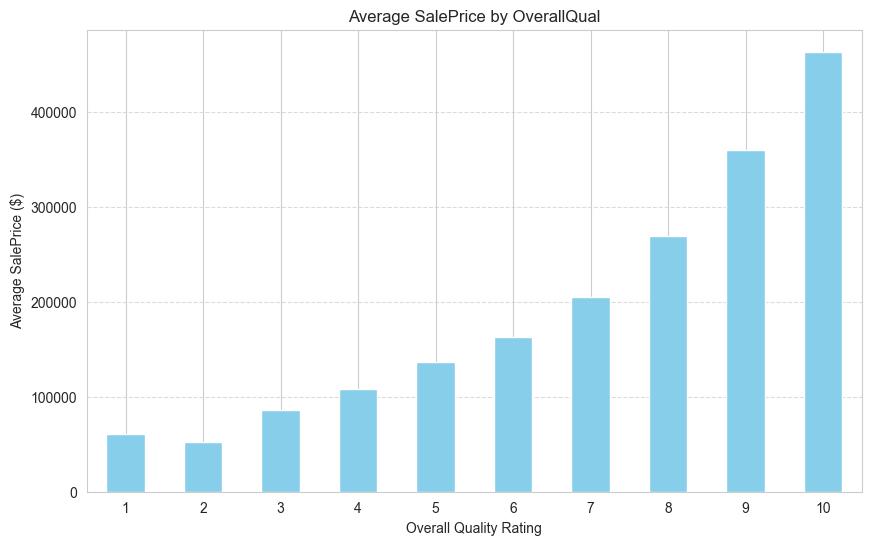

In [290]:
df= Ames.copy()

avg_saleprice = df.groupby('OverallQual')['SalePrice'].mean()

# Sort the results by the OverallQual index to ensure the bars are in order.
avg_saleprice = avg_saleprice.sort_index()

# Create the bar chart.
plt.figure(figsize=(10, 6)) # Set the figure size for better readability
avg_saleprice.plot(kind='bar', color='skyblue')

# Add labels and a title to the chart.
plt.title('Average SalePrice by OverallQual')
plt.xlabel('Overall Quality Rating')
plt.ylabel('Average SalePrice ($)')
plt.xticks(rotation=0) # Keeps x-axis labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7) # Adds a horizontal grid for easier comparison

# Display the plot.
plt.show()

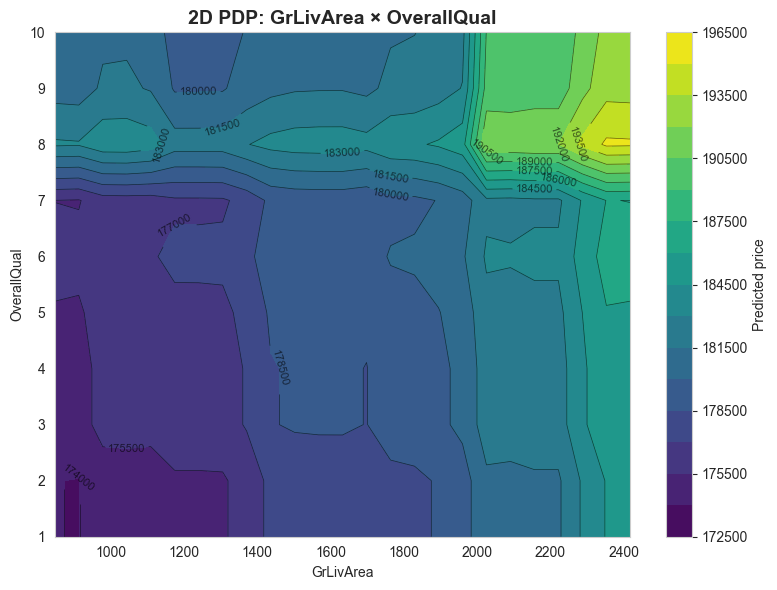

In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 2D PDP: GrLivArea × OverallQual
# -------------------------
feat_x = "GrLivArea"
feat_y = "OverallQual"

# 1) Choose sweep grids
qlo, qhi = X_fe[feat_x].quantile([0.05, 0.95])
x_grid = np.linspace(qlo, qhi, 25)                      # GrLivArea grid (continuous)
y_levels = np.sort(pd.Series(X_fe[feat_y].dropna().unique()).astype(int).unique())
y_grid = y_levels[(y_levels >= X_fe[feat_y].min()) & (y_levels <= X_fe[feat_y].max())]  # integer levels

# 2) Build a "typical" baseline row for all other features
def typical_row(df: pd.DataFrame) -> pd.Series:
    out = {}
    for c in df.columns:
        s = df[c]
        if pd.api.types.is_numeric_dtype(s):
            out[c] = s.median()
        else:
            out[c] = s.mode(dropna=True).iloc[0] if not s.mode(dropna=True).empty else s.dropna().iloc[0]
    return pd.Series(out)

base = typical_row(X_fe)

# 3) Expand grid into a DataFrame, filling others from the baseline
mesh = [(gx, gy) for gy in y_grid for gx in x_grid]
Z_df = pd.DataFrame([base.copy() for _ in range(len(mesh))])
Z_df[feat_x] = [m[0] for m in mesh]
Z_df[feat_y] = [m[1] for m in mesh]

# (Optional) if your pipeline expects TotalBaths, etc., you can plug your helper here
# Z_df = ensure_totalbaths(Z_df, overwrite=False, w_full=1.0, w_half=0.5, w_bfull=1.2, w_bhalf=0.6)

# 4) Predict
Z_pred = cb_final.predict(Z_df)

# 5) Reshape to (len(y_grid), len(x_grid)) for contour plotting
Z = Z_pred.reshape(len(y_grid), len(x_grid))

# 6) Plot
plt.figure(figsize=(8, 6))
levels = 15
cs = plt.contourf(x_grid, y_grid, Z, levels=levels, cmap="viridis")
c = plt.contour(x_grid, y_grid, Z, levels=levels, colors="k", linewidths=0.5, alpha=0.6)
plt.clabel(c, inline=True, fontsize=8, fmt="%.0f")

plt.title("2D PDP: GrLivArea × OverallQual", fontsize=14, weight="bold")
plt.xlabel("GrLivArea")
plt.ylabel("OverallQual")
cb = plt.colorbar(cs)
cb.set_label("Predicted price")
plt.tight_layout()
plt.show()

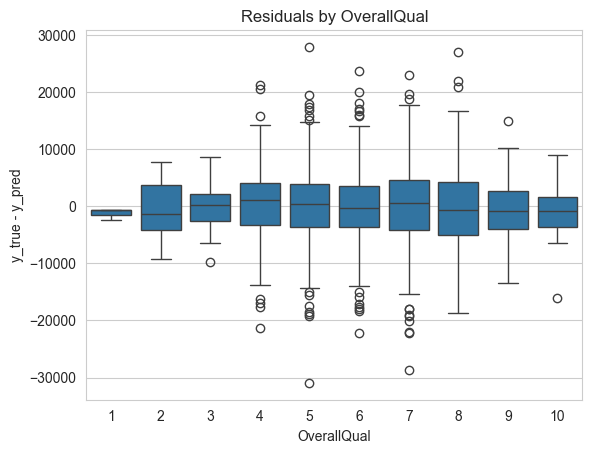

In [292]:
# residuals from your earlier eval table; if you need to recompute:
# base_eval = compute_residuals(cb_final, X_fe, y, id_col="__row_id__")
tmp = pd.concat([X_fe[[feat_x, feat_y]].copy(), base_eval["residual"]], axis=1).dropna()
sns.boxplot(data=tmp, x=feat_y, y="residual")
plt.title("Residuals by OverallQual")
plt.xlabel("OverallQual"); plt.ylabel("y_true - y_pred")
plt.show()

In [293]:
# How many points per (OverallQual, GrLivArea) bin?
bins = pd.cut(X_fe[feat_x], bins=6)
ct = pd.crosstab(X_fe[feat_y].astype(int), bins)
print(ct)

# Optional: mean price by (OverallQual, size-bin)
avg_tbl = (pd.DataFrame({"oq": X_fe[feat_y].astype(int), "bin": bins, "y": y})
           .groupby(["oq","bin"])["y"].mean().unstack())
display(avg_tbl.style.background_gradient(cmap="Blues"))

GrLivArea    (329.658, 1057.667]  (1057.667, 1781.333]  (1781.333, 2505.0]  \
OverallQual                                                                  
1                              2                     1                   0   
2                             12                     1                   0   
3                             22                     9                   1   
4                             93                    92                   9   
5                            285                   401                  59   
6                            102                   459                  95   
7                             13                   332                 162   
8                              4                   140                 115   
9                              0                    28                  36   
10                             0                     1                  10   

GrLivArea    (2505.0, 3228.667]  (3228.667, 3952.333]  (3952.33

bin,"(329.658, 1057.667]","(1057.667, 1781.333]","(1781.333, 2505.0]","(2505.0, 3228.667]","(3228.667, 3952.333]","(3952.333, 4676.0]"
oq,,,,,,
1,50150.000000,81500.000000,nan,nan,nan,nan
2,52102.416667,55000.000000,nan,nan,nan,nan
3,76131.818182,107105.555556,130000.000000,nan,nan,nan
4,97406.000000,115320.500000,134933.333333,160000.000000,nan,nan
5,124144.066667,140251.239401,156780.322034,181071.428571,284700.000000,nan
6,128550.000000,160928.492375,195837.947368,233775.000000,415000.000000,nan
7,133569.230769,192158.500000,229405.000000,263013.470588,295000.000000,nan
8,182000.000000,235723.857143,291696.452174,335044.071429,443000.000000,nan
9,nan,308385.357143,379844.555556,392722.266667,584500.000000,nan


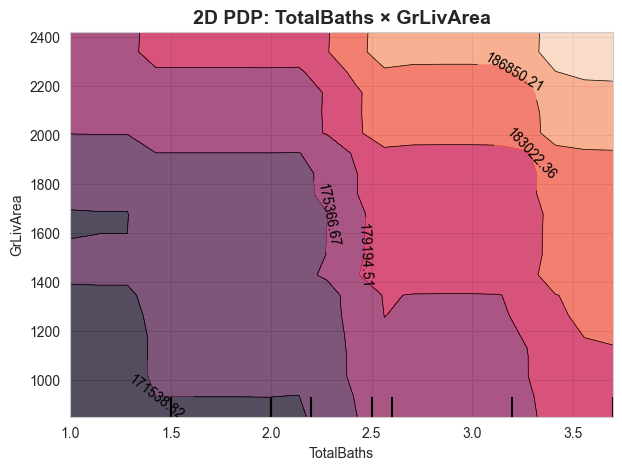

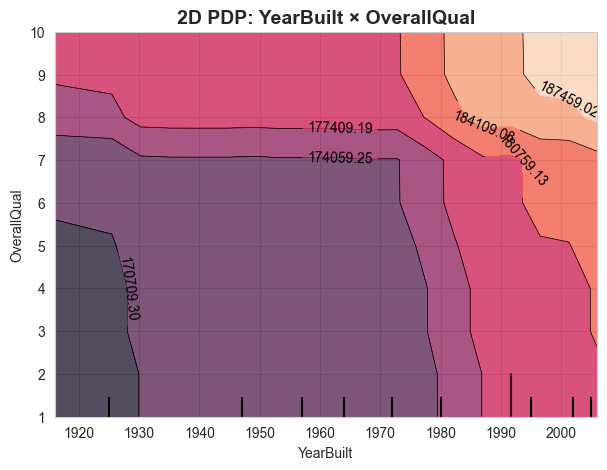

In [294]:
from sklearn.inspection import PartialDependenceDisplay

# --- 1) TotalBaths × GrLivArea ---
fig, ax = plt.subplots(figsize=(7,5))
PartialDependenceDisplay.from_estimator(
    cb_final,
    X_fe,
    features=[("TotalBaths","GrLivArea")],
    kind="average",
    grid_resolution=20,
    ax=ax
)
ax.set_title("2D PDP: TotalBaths × GrLivArea", fontsize=14, weight="bold")
ax.set_xlabel("GrLivArea (Living Area, sqft)")
ax.set_ylabel("TotalBaths")
plt.show()

# --- 2) YearBuilt × OverallQual ---
fig, ax = plt.subplots(figsize=(7,5))
PartialDependenceDisplay.from_estimator(
    cb_final,
    X_fe,
    features=[("YearBuilt","OverallQual")],
    kind="average",
    grid_resolution=20,
    ax=ax
)
ax.set_title("2D PDP: YearBuilt × OverallQual", fontsize=14, weight="bold")
ax.set_xlabel("Year Built")
ax.set_ylabel("Overall Quality")
plt.show()

In [295]:
Ames_geo_original = pd.read_csv('Ames Real Estate Data.csv', index_col=0)

Ames_geo = Ames_geo_original.copy()

In [312]:
Ames_geo.groupby(['MapRefNo','Prop_Addr']).count()

,,GeoRefNo,Tier,Range,ZngCdPr,ZngCdSc,ZngOLPr,ZngOLSc,ClassPr_S,ClassSc_S,Legal_Pr,...,PA-PreD,PA-Strt,PA-StSfx,PA-PostD,PA-UnTyp,PA-UntNo,Date,Source,NmbrBRs,FullAddress
MapRefNo,Prop_Addr,,,,,,,,,,,,,,,,,,,,,
520400001,4599 GEORGE W CARVER AVE,1,1,1,1,0,0,0,1,1,1,...,0,1,1,0,0,0,1,1,0,1
520440010,4507 EVEREST AVE,1,1,1,1,0,0,0,1,1,1,...,0,1,1,0,0,0,1,1,0,1
520440020,4513 EVEREST AVE,1,1,1,1,0,0,0,1,1,1,...,0,1,1,0,0,0,1,1,0,1
520445001,3449 BARCELOS ST,1,1,1,1,0,0,0,1,1,1,...,0,1,1,0,0,0,1,1,0,1
520445010,4506 EVEREST AVE,1,1,1,1,0,0,0,1,1,1,...,0,1,1,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018100010,2400 SE 16TH ST,1,1,1,1,0,1,0,1,1,1,...,1,1,1,0,0,0,1,1,0,1
1018100025,2500 SE 16TH ST,1,1,1,1,0,0,0,1,1,1,...,1,1,1,0,0,0,1,1,0,1
1018100035,2600 SE 16TH ST,1,1,1,1,0,0,0,1,1,1,...,1,1,1,0,0,0,1,1,0,1


In [298]:
Ames

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,SaleCondition,GrLivArea_per_LotArea,TotalSF,HouseAge,HouseAgeSinceRemod,WasRemodeled,TotalBaths,RanchColonial,GrLivArea_x_Qual,TotalSF_x_Qual
1,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,Normal,0.108478,1712.0,71,60,True,2.2,Ranch,5136,10272.0
2,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,Normal,0.247639,2098.0,25,25,False,3.2,Ranch,5245,10490.0
3,911128020,1001,124900,30,C (all),60.0,6060,Pave,NaN,Reg,...,Normal,0.165154,1838.0,77,0,True,1.0,Ranch,5005,9190.0
4,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,...,Normal,0.127532,1444.0,109,6,True,1.0,Colonial,4156,5776.0
5,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,...,Normal,0.198191,2475.0,8,8,False,3.7,Colonial,13320,19800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,903205040,952,121000,30,RL,NaN,8854,Pave,NaN,Reg,...,Normal,0.107510,1904.0,93,59,True,1.0,Other,5712,11424.0
760,905402060,1733,139600,20,RL,NaN,13680,Pave,NaN,IR1,...,Normal,0.126672,1733.0,54,54,False,2.0,Ranch,5199,5199.0
761,909275030,2002,145000,90,RH,82.0,6270,Pave,NaN,Reg,...,Normal,0.319247,3003.0,58,57,True,2.0,Colonial,10010,15015.0
762,907192040,1842,217500,60,RL,NaN,8826,Pave,NaN,Reg,...,Normal,0.208678,2827.0,7,7,False,3.7,Colonial,12894,19789.0


In [299]:
# Create a full address string for geocoding
Ames_geo["FullAddress"] = (
    Ames_geo["PA-Nmbr"].fillna("").astype(str).str.strip() + " " +
    Ames_geo["PA-Strt"].fillna("").str.strip() + " " +
    Ames_geo["PA-StSfx"].fillna("").str.strip() + " " +
    Ames_geo["PA-PostD"].fillna("").str.strip() + ", Ames, IA"
).str.replace("  ", " ").str.strip()

In [313]:
import pandas as pd

# 1) Load the two datasets
# Ames is your modeling dataset
# Ames_geo is the assessor dataset
# Assuming they are already loaded into Ames and Ames_geo

# 2) Ensure keys are same dtype (PID ↔ MapRefNo)
Ames["PID"] = Ames["PID"].astype(str)
Ames_geo = Ames_geo.reset_index()
Ames_geo["MapRefNo"] = Ames_geo["MapRefNo"].astype(str)

# 3) Filter assessor data to only rows in Ames
Ames_geo_filtered = Ames_geo[Ames_geo["MapRefNo"].isin(Ames["PID"])].copy()

print("Original assessor rows:", len(Ames_geo))
print("Filtered to Ames rows:", len(Ames_geo_filtered))

Original assessor rows: 22213
Filtered to Ames rows: 2602


In [316]:
import re
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderUnavailable, GeocoderTimedOut
from tqdm import tqdm

tqdm.pandas()  # progress bars for apply

# --- 0) Build / clean the address string from your columns -------------------
# If you already assembled FullAddress, adapt the cleaner below to that column.
def clean_address(addr: str) -> str:
    if pd.isna(addr):
        return ""
    s = str(addr)
    # remove trailing ".0" from house numbers
    s = re.sub(r"\b(\d+)\.0\b", r"\1", s)
    # collapse double spaces/commas
    s = re.sub(r"\s{2,}", " ", s)
    s = re.sub(r",\s*,", ", ", s)
    s = s.strip(" ,")
    # ensure city+state; adjust if your column already includes it
    if "AMES" not in s.upper():
        s = f"{s}, Ames, IA"
    return s

# Suppose your filtered dataframe is Ames_geo_filtered and has column "Prop_Addr"
df = Ames_geo_filtered.copy()
df["FullAddress"] = df["Prop_Addr"].fillna("").astype(str).apply(clean_address)

# Keep only rows that match your Ames PID set:
# (If you already did this filter, skip)
# df = df[df.index.astype(str).isin(ames_pid_set)]

# --- 1) Geocode uniques only -------------------------------------------------
# unique, non-empty addresses
addr_unique = (
    df.loc[df["FullAddress"].str.len() > 0, "FullAddress"]
      .drop_duplicates()
      .to_frame(name="FullAddress")
      .reset_index(drop=True)
)

# --- 2) Configure Nominatim with sane timeouts and a local viewbox ----------
# Ames bounding box (rough): lat ~ [41.98, 42.08], lon ~ [-93.72, -93.57]
# Nominatim expects viewbox=(min_lon, min_lat, max_lon, max_lat)
AMES_VIEWBOX = (-93.72, 41.98, -93.57, 42.08)

geolocator = Nominatim(user_agent="ames-housing-ds-bootcamp", timeout=10)

def safe_geocode(q):
    try:
        return geolocator.geocode(
            q,
            addressdetails=False,
            limit=1,
            viewbox=AMES_VIEWBOX,
            bounded=True,  # confine to viewbox
        )
    except (GeocoderTimedOut, GeocoderUnavailable, Exception):
        return None

# Respect Nominatim rate limits. Go slower if you still see timeouts.
geocode = RateLimiter(
    safe_geocode,
    min_delay_seconds=1.2,   # ~1 req/sec is polite; increase if you see many timeouts
    max_retries=3,
    error_wait_seconds=8,
    swallow_exceptions=True, # don't crash; return None
)

# --- 3) Run on a small sample first (e.g., 50) to validate -------------------
sample = addr_unique.head(50).copy()
sample["location"] = sample["FullAddress"].progress_apply(geocode)
sample["Lat"] = sample["location"].apply(lambda loc: loc.latitude if loc else np.nan)
sample["Lon"] = sample["location"].apply(lambda loc: loc.longitude if loc else np.nan)

print("Sample success rate:", sample["Lat"].notna().mean())

# If results look good, switch `sample` -> `addr_unique` and re-run
# addr_unique["location"] = addr_unique["FullAddress"].progress_apply(geocode)
# addr_unique["Lat"] = addr_unique["location"].apply(lambda loc: loc.latitude if loc else np.nan)
# addr_unique["Lon"] = addr_unique["location"].apply(lambda loc: loc.longitude if loc else np.nan)

# --- 4) Map results back to your full filtered dataframe --------------------
# Do the merge with `sample` for testing; use `addr_unique` for full run later.
geo_map = sample[["FullAddress", "Lat", "Lon"]].copy()
df = df.merge(geo_map, on="FullAddress", how="left")

# Inspect a few
print(df[["Prop_Addr", "FullAddress", "Lat", "Lon"]].head(10))

100%|███████████████████████████████████████████| 50/50 [00:58<00:00,  1.18s/it]

Sample success rate: 0.0
           Prop_Addr                  FullAddress  Lat  Lon
0     3109 GROVE AVE     3109 GROVE AVE, Ames, IA  NaN  NaN
1   630 RIVER OAK DR   630 RIVER OAK DR, Ames, IA  NaN  NaN
2   620 RIVER OAK DR   620 RIVER OAK DR, Ames, IA  NaN  NaN
3     3010 GROVE AVE     3010 GROVE AVE, Ames, IA  NaN  NaN
4  3126 NORTHWOOD DR  3126 NORTHWOOD DR, Ames, IA  NaN  NaN
5  3115 NORTHWOOD DR  3115 NORTHWOOD DR, Ames, IA  NaN  NaN
6  3113 NORTHWOOD DR  3113 NORTHWOOD DR, Ames, IA  NaN  NaN
7   623 RIVER OAK DR   623 RIVER OAK DR, Ames, IA  NaN  NaN
8   627 RIVER OAK DR   627 RIVER OAK DR, Ames, IA  NaN  NaN
9   3006 KELLOGG AVE   3006 KELLOGG AVE, Ames, IA  NaN  NaN


In [320]:
import re
import numpy as np
import pandas as pd
from geopy.geocoders import ArcGIS, Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderUnavailable, GeocoderTimedOut
from tqdm import tqdm

tqdm.pandas()

# 1) Clean addresses
def clean_address(addr: str) -> str:
    if pd.isna(addr):
        return ""
    s = str(addr).strip()
    # remove trailing ".0" from numbers
    s = re.sub(r"\b(\d+)\.0\b", r"\1", s)
    # collapse spaces and stray commas
    s = re.sub(r"\s{2,}", " ", s)
    s = re.sub(r",\s*,", ", ", s)
    s = s.strip(" ,")
    # ensure city, state, country
    if "AMES" not in s.upper():
        s = f"{s}, Ames, IA, USA"
    elif "USA" not in s.upper():
        s = f"{s}, USA"
    return s

# df should be your Ames_geo_filtered (already reduced to PIDs that exist in Ames)
df = Ames_geo_filtered.copy()
df["FullAddress"] = df["Prop_Addr"].fillna("").astype(str).apply(clean_address)

# 2) Unique, non-empty addresses
addr_unique = (
    df.loc[df["FullAddress"].str.len() > 0, "FullAddress"]
      .drop_duplicates()
      .to_frame(name="FullAddress")
      .reset_index(drop=True)
)

# 3) Geocoders + rate limiters (no tight viewbox)
arc = ArcGIS(timeout=15)  # forgiving for US addresses
nom = Nominatim(user_agent="ames-housing-ds-bootcamp", timeout=20)

arc_geocode = RateLimiter(arc.geocode, min_delay_seconds=1.0,
                          max_retries=2, error_wait_seconds=5, swallow_exceptions=True)
nom_geocode = RateLimiter(nom.geocode, min_delay_seconds=1.2,
                          max_retries=2, error_wait_seconds=5, swallow_exceptions=True)

def geocode_with_fallback(q):
    try:
        loc = arc_geocode(q)      # ArcGIS first
        if not loc:
            loc = nom_geocode(q)  # fall back to Nominatim
        return loc
    except (GeocoderTimedOut, GeocoderUnavailable, Exception):
        return None

# 4) Try a small sample first
sample = addr_unique.head(50).copy()
sample["location"] = sample["FullAddress"].progress_apply(geocode_with_fallback)
sample["Lat"] = sample["location"].apply(lambda loc: loc.latitude if loc else np.nan)
sample["Lon"] = sample["location"].apply(lambda loc: loc.longitude if loc else np.nan)

print("Sample success rate:", sample["Lat"].notna().mean())
print(sample.head(10))

# 5) Map back to the filtered DF
geo_map = sample[["FullAddress", "Lat", "Lon"]].copy()
df_geo_sample = df.merge(geo_map, on="FullAddress", how="left")

# Inspect failures to see patterns
fails = df_geo_sample[df_geo_sample["Lat"].isna()][["Prop_Addr","FullAddress"]].head(20)
print("Examples of failed lookups:\n", fails)

100%|███████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]

Sample success rate: 1.0
                        FullAddress  \
0     3109 GROVE AVE, Ames, IA, USA   
1   630 RIVER OAK DR, Ames, IA, USA   
2   620 RIVER OAK DR, Ames, IA, USA   
3     3010 GROVE AVE, Ames, IA, USA   
4  3126 NORTHWOOD DR, Ames, IA, USA   
5  3115 NORTHWOOD DR, Ames, IA, USA   
6  3113 NORTHWOOD DR, Ames, IA, USA   
7   623 RIVER OAK DR, Ames, IA, USA   
8   627 RIVER OAK DR, Ames, IA, USA   
9   3006 KELLOGG AVE, Ames, IA, USA   

                                            location        Lat        Lon  
0  (3109 Grove Ave, Ames, Iowa, 50010, (42.052900...  42.052900 -93.619968  
1  (630 River Oak Dr, Ames, Iowa, 50010, (42.0526...  42.052672 -93.619393  
2  (620 River Oak Dr, Ames, Iowa, 50010, (42.0525...  42.052548 -93.618847  
3  (3010 Grove Ave, Ames, Iowa, 50010, (42.051911...  42.051911 -93.619366  
4  (3126 Northwood Dr, Ames, Iowa, 50010, (42.053...  42.053903 -93.617879  
5  (3115 Northwood Dr, Ames, Iowa, 50010, (42.053...  42.053471 -93.618412  
6  (31

In [336]:
df_geo_sample

,MapRefNo,GeoRefNo,Tier,Range,Prop_Addr,ZngCdPr,ZngCdSc,ZngOLPr,ZngOLSc,ClassPr_S,...,PA-StSfx,PA-PostD,PA-UnTyp,PA-UntNo,Date,Source,NmbrBRs,FullAddress,Lat,Lon
0,526350040,526350040,0,0,3109 GROVE AVE,RH,NaN,NaN,NaN,RESIDENTIAL,...,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,2.0,"3109 GROVE AVE, Ames, IA, USA",42.052900,-93.619968
1,526351010,526351010,0,0,630 RIVER OAK DR,RL,NaN,NaN,NaN,RESIDENTIAL,...,DR,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0,"630 RIVER OAK DR, Ames, IA, USA",42.052672,-93.619393
2,526351030,526351030,0,0,620 RIVER OAK DR,RL,NaN,NaN,NaN,RESIDENTIAL,...,DR,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0,"620 RIVER OAK DR, Ames, IA, USA",42.052548,-93.618847
3,526351100,526351100,0,0,3010 GROVE AVE,RL,NaN,NaN,NaN,RESIDENTIAL,...,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,4.0,"3010 GROVE AVE, Ames, IA, USA",42.051911,-93.619366
4,526301100,526301100,0,0,3126 NORTHWOOD DR,RL,NaN,NaN,NaN,RESIDENTIAL,...,DR,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0,"3126 NORTHWOOD DR, Ames, IA, USA",42.053903,-93.617879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,923275140,923275140,0,0,3803 MINNETONKA AVE,RL,NaN,NaN,NaN,RESIDENTIAL,...,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0,"3803 MINNETONKA AVE, Ames, IA, USA",NaN,NaN
2598,923275200,923275200,0,0,3827 MINNETONKA AVE,RL,NaN,NaN,NaN,RESIDENTIAL,...,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,2.0,"3827 MINNETONKA AVE, Ames, IA, USA",NaN,NaN
2599,923276030,923276030,0,0,615 GARDEN RD,RL,NaN,O-E,NaN,RESIDENTIAL,...,RD,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,2.0,"615 GARDEN RD, Ames, IA, USA",NaN,NaN
2600,923276100,923276100,0,0,719 GARDEN RD,RL,NaN,O-E,NaN,RESIDENTIAL,...,RD,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,2.0,"719 GARDEN RD, Ames, IA, USA",NaN,NaN


In [333]:
# 0) Make copies so we don't mutate originals
ames = ames.copy()
geo  = Ames_geo.copy()

# 1) Normalize join keys as *columns* (not index) → strings of ints with no decimals
ames["PID_key"] = pd.to_numeric(ames["PID"], errors="coerce").astype("Int64").astype(str)
geo["MapRefNo_key"] = pd.to_numeric(geo["MapRefNo"], errors="coerce").astype("Int64").astype(str)

print("Ames PID raw (col):", ames["PID"].head(5).tolist())
print("Geo MapRefNo raw (col):", geo["MapRefNo"].head(5).tolist())

# 2) Quick overlap sanity check
pid_set = set(ames["PID_key"].dropna())
geo_set = set(geo["MapRefNo_key"].dropna())
overlap = pid_set & geo_set
print("Overlap count:", len(overlap))
print("Overlap sample:", list(overlap)[:10])

# 3) Filter geo to only PIDs present in Ames
geo_filtered = geo[geo["MapRefNo_key"].isin(pid_set)].copy()
print("Filtered geo rows:", len(geo_filtered))

# 4) (Optional) build a clean full address string on the filtered geo for geocoding
import numpy as np
import pandas as pd

def _as_text(x):
    """Coerce any value to a clean string; handle NaN and floats like 4507.0 -> '4507'."""
    if pd.isna(x):
        return ""
    # numeric house numbers often come as floats with .0
    if isinstance(x, (int, np.integer)):
        return str(x)
    if isinstance(x, float):
        return str(int(x)) if x.is_integer() else str(x)
    return str(x)

def build_full_address(row):
    # Pull parts and sanitize
    num    = _as_text(row.get("PA-Nmbr"))
    pre    = _as_text(row.get("PA-PreD"))
    street = _as_text(row.get("PA-Strt"))
    sfx    = _as_text(row.get("PA-StSfx"))
    post   = _as_text(row.get("PA-PostD"))
    # Assemble, dropping empties / 'nan'
    parts = [p.strip() for p in [num, pre, street, sfx, post] if p and p.strip().lower() != "nan"]

    if not parts:
        # fall back to Prop_Addr if structured parts are missing
        prop = _as_text(row.get("Prop_Addr")).strip()
        if prop and prop.lower() != "nan":
            parts = [prop]

    return (" ".join(parts) + ", Ames, IA, USA") if parts else ""

# --- Guard: only try to build if we actually have rows to process
if len(geo_filtered) == 0:
    print("geo_filtered is empty — double-check your PID ↔ MapRefNo key normalization and overlap.")
else:
    geo_filtered = geo_filtered.copy()
    geo_filtered["FullAddress"] = geo_filtered.apply(build_full_address, axis=1)
    print(geo_filtered[["MapRefNo", "Prop_Addr", "PA-Nmbr", "PA-PreD", "PA-Strt", "PA-StSfx", "PA-PostD", "FullAddress"]].head(10))

Ames PID raw (col): ['909176150', '905476230', '911128020', '535377150', '534177230']
Geo MapRefNo raw (col): ['520400001', '520440010', '520440020', '520445001', '520445010']
Overlap count: 2558
Overlap sample: ['534250010', '535426130', '528172020', '527402220', '905401060', '907203060', '528441020', '905101450', '528142110', '531453040']
Filtered geo rows: 2602
      MapRefNo          Prop_Addr PA-Nmbr PA-PreD    PA-Strt PA-StSfx  \
113  526350040     3109 GROVE AVE  3109.0     NaN      GROVE      AVE   
118  526351010   630 RIVER OAK DR   630.0     NaN  RIVER OAK       DR   
120  526351030   620 RIVER OAK DR   620.0     NaN  RIVER OAK       DR   
127  526351100     3010 GROVE AVE  3010.0     NaN      GROVE      AVE   
272  526301100  3126 NORTHWOOD DR  3126.0     NaN  NORTHWOOD       DR   
276  526302030  3115 NORTHWOOD DR  3115.0     NaN  NORTHWOOD       DR   
277  526302040  3113 NORTHWOOD DR  3113.0     NaN  NORTHWOOD       DR   
284  526302110   623 RIVER OAK DR   623.0     NaN

In [334]:
# How many non-empty addresses did we build?
nonempty = (geo_filtered["FullAddress"].str.len() > 0).sum()
print("Non-empty FullAddress rows:", nonempty, "of", len(geo_filtered))

# Spot check a few fully-assembled examples
print(geo_filtered.loc[geo_filtered["FullAddress"].str.len() > 0, ["Prop_Addr","FullAddress"]].head(5))

Non-empty FullAddress rows: 2602 of 2602
             Prop_Addr                       FullAddress
113     3109 GROVE AVE     3109 GROVE AVE, Ames, IA, USA
118   630 RIVER OAK DR   630 RIVER OAK DR, Ames, IA, USA
120   620 RIVER OAK DR   620 RIVER OAK DR, Ames, IA, USA
127     3010 GROVE AVE     3010 GROVE AVE, Ames, IA, USA
272  3126 NORTHWOOD DR  3126 NORTHWOOD DR, Ames, IA, USA


In [337]:
geo_filtered

,MapRefNo,GeoRefNo,Tier,Range,Prop_Addr,ZngCdPr,ZngCdSc,ZngOLPr,ZngOLSc,ClassPr_S,...,PA-StSfx,PA-PostD,PA-UnTyp,PA-UntNo,Date,Source,NmbrBRs,FullAddress,PID_clean,MapRefNo_key
113,526350040,526350040,0,0,3109 GROVE AVE,RH,NaN,NaN,NaN,RESIDENTIAL,...,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,2.0,"3109 GROVE AVE, Ames, IA, USA",113,526350040
118,526351010,526351010,0,0,630 RIVER OAK DR,RL,NaN,NaN,NaN,RESIDENTIAL,...,DR,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0,"630 RIVER OAK DR, Ames, IA, USA",118,526351010
120,526351030,526351030,0,0,620 RIVER OAK DR,RL,NaN,NaN,NaN,RESIDENTIAL,...,DR,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0,"620 RIVER OAK DR, Ames, IA, USA",120,526351030
127,526351100,526351100,0,0,3010 GROVE AVE,RL,NaN,NaN,NaN,RESIDENTIAL,...,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,4.0,"3010 GROVE AVE, Ames, IA, USA",127,526351100
272,526301100,526301100,0,0,3126 NORTHWOOD DR,RL,NaN,NaN,NaN,RESIDENTIAL,...,DR,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0,"3126 NORTHWOOD DR, Ames, IA, USA",272,526301100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22097,923275140,923275140,0,0,3803 MINNETONKA AVE,RL,NaN,NaN,NaN,RESIDENTIAL,...,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0,"3803 MINNETONKA AVE, Ames, IA, USA",22097,923275140
22103,923275200,923275200,0,0,3827 MINNETONKA AVE,RL,NaN,NaN,NaN,RESIDENTIAL,...,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,2.0,"3827 MINNETONKA AVE, Ames, IA, USA",22103,923275200
22106,923276030,923276030,0,0,615 GARDEN RD,RL,NaN,O-E,NaN,RESIDENTIAL,...,RD,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,2.0,"615 GARDEN RD, Ames, IA, USA",22106,923276030
22113,923276100,923276100,0,0,719 GARDEN RD,RL,NaN,O-E,NaN,RESIDENTIAL,...,RD,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,2.0,"719 GARDEN RD, Ames, IA, USA",22113,923276100


In [338]:
import pandas as pd

# Load the merged file (best for mapping / modeling)
ames_geo = pd.read_csv("ames_with_latlon.csv")

print(ames_geo.head())
print("Rows with coordinates:", ames_geo["Lat"].notna().sum())
print("Success rate:", ames_geo["Lat"].notna().mean())

   index   MapRefNo   GeoRefNo  Tier  Range          Prop_Addr ZngCdPr  \
0    113  526350040  526350040     0      0     3109 GROVE AVE      RH   
1    118  526351010  526351010     0      0   630 RIVER OAK DR      RL   
2    120  526351030  526351030     0      0   620 RIVER OAK DR      RL   
3    127  526351100  526351100     0      0     3010 GROVE AVE      RL   
4    272  526301100  526301100     0      0  3126 NORTHWOOD DR      RL   

  ZngCdSc ZngOLPr ZngOLSc  ... PA-PostD PA-UnTyp PA-UntNo       Date  \
0     NaN     NaN     NaN  ...      NaN      NaN      NaN  10-Jul-20   
1     NaN     NaN     NaN  ...      NaN      NaN      NaN  10-Jul-20   
2     NaN     NaN     NaN  ...      NaN      NaN      NaN  10-Jul-20   
3     NaN     NaN     NaN  ...      NaN      NaN      NaN  10-Jul-20   
4     NaN     NaN     NaN  ...      NaN      NaN      NaN  10-Jul-20   

               Source NmbrBRs                       FullAddress MapRefNo_key  \
0  Ames City Assessor     2.0     3109 GRO

In [479]:
ames_geo_clean = ames_geo.dropna(subset=["Lat", "Lon"]).copy()

In [490]:
ames_geo_clean = ames_geo_clean.rename(columns={'MapRefNo':'PID'})

In [491]:
print(ames_geo_clean[['PID', 'FullAddress','Lat','Lon']])

            PID                         FullAddress        Lat        Lon
0     526350040       3109 GROVE AVE, Ames, IA, USA  42.052806 -93.619783
1     526351010     630 RIVER OAK DR, Ames, IA, USA  42.052700 -93.618833
2     526351030     620 RIVER OAK DR, Ames, IA, USA  42.052681 -93.618734
3     526351100       3010 GROVE AVE, Ames, IA, USA  42.051488 -93.619526
4     526301100    3126 NORTHWOOD DR, Ames, IA, USA  42.053808 -93.618344
...         ...                                 ...        ...        ...
2597  923275140  3803 MINNETONKA AVE, Ames, IA, USA  41.988229 -93.604036
2598  923275200  3827 MINNETONKA AVE, Ames, IA, USA  41.988232 -93.604358
2599  923276030        615 GARDEN RD, Ames, IA, USA  41.988915 -93.603718
2600  923276100        719 GARDEN RD, Ames, IA, USA  41.988322 -93.602641
2601  923276180        636 GARDEN RD, Ames, IA, USA  41.988449 -93.603316

[2568 rows x 4 columns]


In [494]:
Ames['PID']

1      909176150
2      905476230
3      911128020
4      535377150
5      534177230
         ...    
759    903205040
760    905402060
761    909275030
762    907192040
763    906223180
Name: PID, Length: 2580, dtype: object

Ames PID_key dtype: object | example: 909176150
Geo  PID_key dtype: object | example: 526350040
Rows in Ames: 2580 | with coordinates: 2525


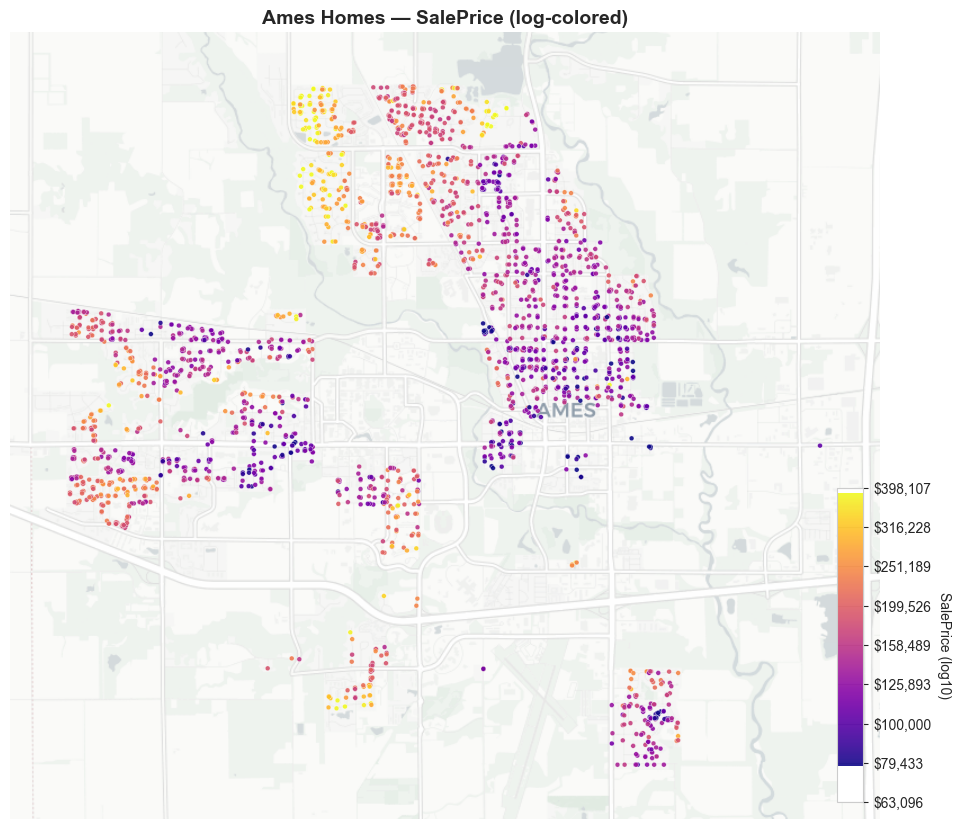

Plotted homes: 2525


In [495]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- 0) Helper to normalize PIDs to the same string form ---------------------
def clean_key(x):
    """
    Convert PID to a comparable string of digits.
    - Works for ints or strings.
    - Strips non-digits and leading zeros.
    """
    s = str(x)
    # keep only digits
    digits = "".join(ch for ch in s if ch.isdigit())
    # drop leading zeros but keep '0' if everything was zeros/empty
    digits = digits.lstrip("0") or "0"
    return digits

# --- 1) Build comparable keys on both tables ---------------------------------
# Ames is assumed to be already in memory
ames = Ames.copy()

# Keep the columns we need from geo and ensure uniqueness per PID
geo_cols = ["PID", "FullAddress", "Lat", "Lon"]
geo_min = (ames_geo_clean[geo_cols]
           .dropna(subset=["Lat","Lon"])
           .drop_duplicates(subset=["PID"], keep="first")
           .copy())

# Build normalized keys (strings) on both sides
ames["PID_key"]   = ames["PID"].apply(clean_key)
geo_min["PID_key"] = geo_min["PID"].apply(clean_key)

# (Optional) sanity checks
print("Ames PID_key dtype:", ames["PID_key"].dtype, "| example:", ames["PID_key"].iloc[0])
print("Geo  PID_key dtype:", geo_min["PID_key"].dtype, "| example:", geo_min["PID_key"].iloc[0])

# --- 2) Merge lat/lon onto Ames via the normalized key -----------------------
Ames_map = ames.merge(
    geo_min[["PID_key","FullAddress","Lat","Lon"]],
    on="PID_key", how="left", validate="m:1"  # each home -> at most one geo row
)

print(
    "Rows in Ames:", len(Ames_map),
    "| with coordinates:", Ames_map["Lat"].notna().sum()
)

# --- 3) Plot homes colored by log10(SalePrice) -------------------------------
# Keep only rows we can plot
df = Ames_map.dropna(subset=["Lat","Lon","SalePrice"]).copy()
if df.empty:
    raise RuntimeError("No rows left after filtering for Lat/Lon/SalePrice. Check merge keys and column names.")

# Create GeoDataFrame in Web Mercator for tiled basemap
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Lon"], df["Lat"]),
    crs="EPSG:4326"
).to_crs(3857)

# Extent padding
minx, miny, maxx, maxy = gdf.total_bounds
padx, pady = (maxx-minx)*0.08, (maxy-miny)*0.08

# Log color scale (robust to outliers)
gdf["logPrice"] = np.log10(gdf["SalePrice"].clip(lower=1))
vmin, vmax = np.percentile(gdf["logPrice"], [2, 98])

# Figure
fig, ax = plt.subplots(figsize=(9, 10))

pts = gdf.plot(
    ax=ax,
    column="logPrice",
    cmap="plasma",
    vmin=vmin, vmax=vmax,
    markersize=12,
    alpha=0.9,
    edgecolor="white", linewidth=0.25,
)

# Basemap + framing
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution=False)
ax.set_xlim(minx-padx, maxx+padx)
ax.set_ylim(miny-pady, maxy+pady)
ax.set_axis_off()
ax.set_title("Ames Homes — SalePrice (log-colored)", fontsize=14, weight="bold")

# Colorbar (parked away from the map/legends)
cax = inset_axes(ax, width="3%", height="40%", loc="lower right", borderpad=1.2)
cb  = plt.colorbar(pts.collections[0], cax=cax)
ticks = cb.get_ticks()
cb.set_ticks(ticks)
cb.set_ticklabels([f"${10**t:,.0f}" for t in ticks])
cb.set_label("SalePrice (log10)", rotation=270, labelpad=14)

plt.tight_layout()
plt.show()

print("Plotted homes:", len(gdf))